In [1]:
import matplotlib as mpl
import pandas as pd
import scanpy as sc
import seaborn as sns
import pathlib
%matplotlib inline
import os
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

savefig_args = {
    "dpi": 300,
    "bbox_inches": "tight",
    "pad_inches": 0.1,
    "transparent": True,
}

mpl.rc("savefig", dpi=300)
output_dir="sharing_GEX/"
output_suffix = ""
output_formats = [".png", ".pdf"]

sc.set_figure_params(dpi_save=150, frameon=False,
 vector_friendly=True, fontsize=6, figsize=(3,3), format='pdf', transparent=True)

pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", 20)
pd.set_option("display.width", 100)
%load_ext autoreload
%autoreload 2
%run ../helper.py

def save_figure(
    fig,
    name,
    output_dir=output_dir,
    output_suffix=output_suffix,
    output_formats=output_formats,
    savefig_args=savefig_args,
):
    for output_format in output_formats:
        fig.savefig(
            output_dir + "/" + name + output_suffix + output_format, **savefig_args
        )
    return None

sns.set_style("ticks")
plt.style.use('../bursa.mplstyle')

## Custom Functions

In [2]:
def plot_custom_dotplot(ad, markers):
    # dot plot creation
    dp = sc.pl.DotPlot(ad, markers, groupby= 'shared', figsize = (2, 2.25), vmax = 2, vmin = 0,  expression_cutoff = 0)
    dp.legend(width=0.8)
    dp.swap_axes()
    dp.add_totals(color = '0.4', size = 0.3,).style(dot_edge_color='black', largest_dot = 40 , dot_edge_lw=0.2, cmap = 'Purples').show()

    # get axes for tweaking out
    axes = dp.get_axes()

    for child in axes['group_extra_ax'].get_children():
        if isinstance(child, mpl.text.Annotation):
        # print("bingo") # and do something
        # print(round_string(child.get_text()))
            child.set(rotation=90, verticalalignment='bottom')
        # print(child)
    # First, remove the current title
    axes['size_legend_ax'].set_title("")
    axes['size_legend_ax'].tick_params(axis='x', which = 'minor', length=0)
    axes['size_legend_ax'].tick_params(axis='x', labelsize=5)

    # Then, create a new title using a text object
    title = "% cells\nexpression > 0"
    axes['size_legend_ax'].text(0, 0.8, title, transform=axes['size_legend_ax'].transAxes, 
                                va='center', ha='left', fontsize = 5)

    title = "Mean Expression\n($log_2$ UMI per 10K)"
    axes['color_legend_ax'].set_title("")
    axes['color_legend_ax'].text(0, 2.2, title, transform=axes['color_legend_ax'].transAxes, 
                                va='center', ha='left', fontsize = 5)
    axes['color_legend_ax'].tick_params(axis='x', labelsize=5)

    # Get the bounding box of the main plot
    mainplot_box = axes['mainplot_ax'].get_position()
    for bar in axes['group_extra_ax'].patches:
        bar.set_edgecolor('none')
    ax = axes['mainplot_ax']
    # add label
    #y_text_loc = ax.get_yticks()[(len(canonical_markers)) - 5]
    #x_text_loc = ax.get_xticks()[-1] + 1
    #ax.text(x_text_loc, y_text_loc, 'Canonical', rotation=-90, fontsize = 6)
    # add label
    #y_text_loc = ax.get_yticks()[13] + 4.5
    #x_text_loc = ax.get_xticks()[-1] + 1
    #ax.text(x_text_loc, y_text_loc, 'Data-Derived', rotation=-90, fontsize = 6)
    return dp

### Load the Data

In [3]:
# configuration:
h5ad = 'TBd6_sharing.h5ad.gz'
#h5ad = 'all_sharing.h5ad.gz'
tissue_combo = 'LN_SP'
# this is empty for now because I don't think they are useful for the dotplots atm
canonical_markers = []
mb_subtypes = "../annotate/outputs/MB_subtypes.tab"
# Dictionary to map tissue_combo to DataFrame columns
tissue_combo_to_column = {
    'LN_LN': 'shared_LN_LN',
    'LN_SP': 'shared_LN_SP',
    'LN_PB': 'shared_LN_PB',
    "BM_PB": 'shared_BM_PB',
    "SP_PB": 'shared_SP_PB',
    "SP_BM": 'shared_SP_BM',
    'LN_BM': 'shared_LN_BM',   
    # Add more mappings as needed
}

In [4]:
def convert_boolean_columns(df):

    """

    Convert columns in a DataFrame that are likely to be boolean strings to boolean type.

    

    Parameters:

    - df: pd.DataFrame

        The DataFrame to process.

    

    Returns:

    - pd.DataFrame

        The DataFrame with appropriate columns converted to boolean type.

    """

    

    for col in df.columns:

        unique_values = df[col].dropna().unique()

        

        # If the unique non-null values in the column are "True" and "False", assume it's a boolean column

        if set(unique_values) == {'True', 'False'}:

            df[col] = df[col].replace({'True': True, 'False': False}).astype('boolean')

        

        # If the column contains "True", "False", and "nan", assume it's a boolean column with NaNs

        elif set(unique_values) == {'True', 'False'} or set(unique_values) == {'True', 'False', 'nan'}:

            df[col] = df[col].replace({'True': True, 'False': False, 'nan': np.nan}).astype('boolean')

            

    return df

In [5]:
adata = sc.read_h5ad(h5ad)


In [6]:
# Subset to Memory B cells
mb_adata = adata[adata.obs.celltypist.str.contains('Memory B|Age|Prolif')]
asc_adata = adata[adata.obs.celltypist.str.contains("Plasma")]
print(mb_adata.obs.shape, "Memory B cells to analyze")
print(asc_adata.obs.shape, "Memory B cells to analyze")
# add the memB subtype labels
labels = pd.read_table(mb_subtypes, index_col = 0)
mb_adata.obs = pd.merge(mb_adata.obs, labels, left_index=True, right_index=True, how='left')
mb_adata_LN = mb_adata[mb_adata.obs.tissue == 'LN']

(12710, 21) Memory B cells to analyze
(4908, 21) Memory B cells to analyze


## Calculate DE genes between the groups

12710 cells
12710 cells after removing nans in shared

 LN_LN 
 mb_cells 






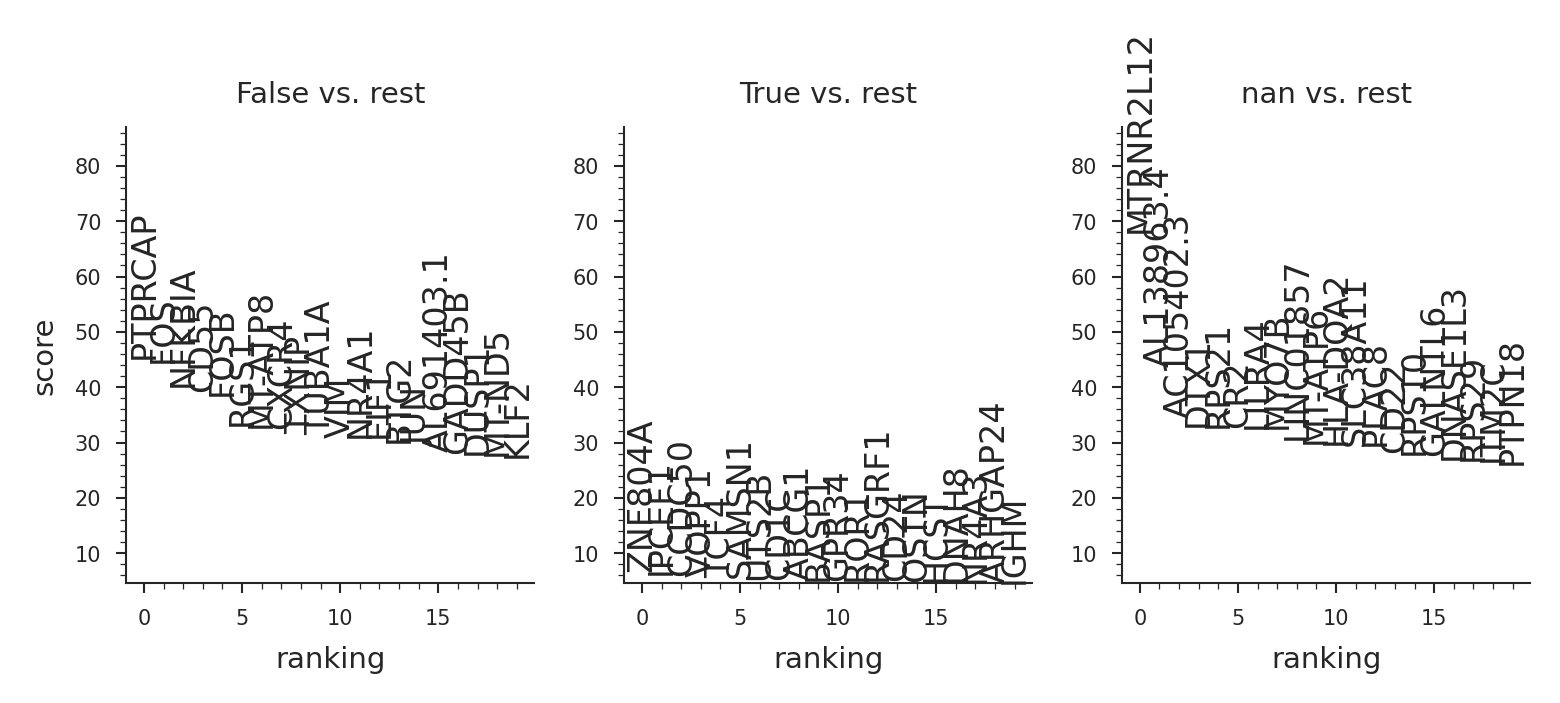

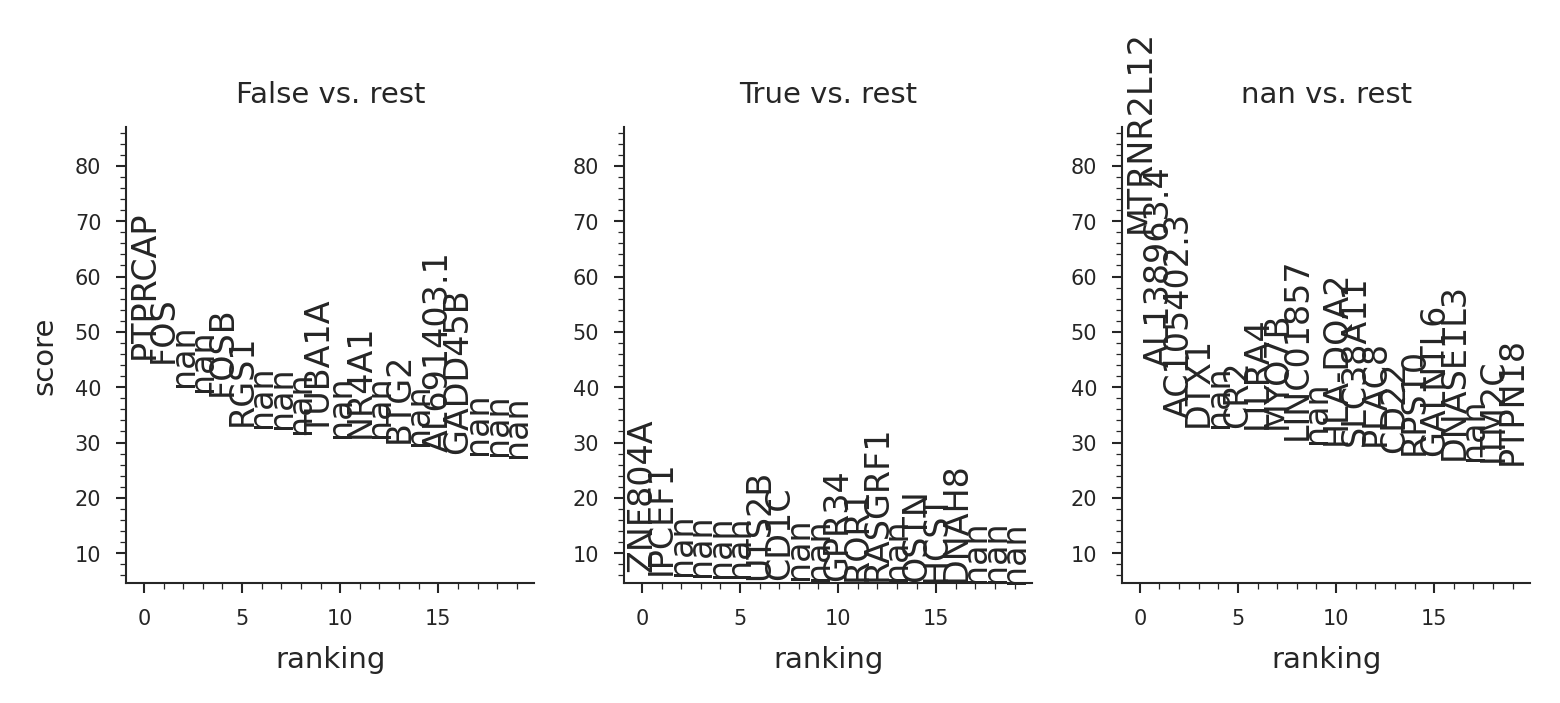

/home/michaelswift/miniconda3/envs/scanpy_new/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


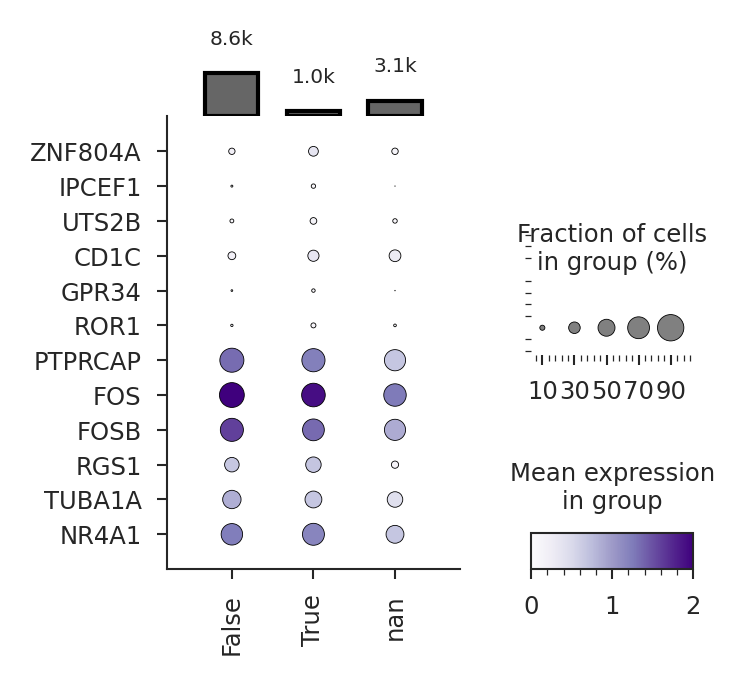

4908 cells
4908 cells after removing nans in shared

 LN_LN 
 as_cells 






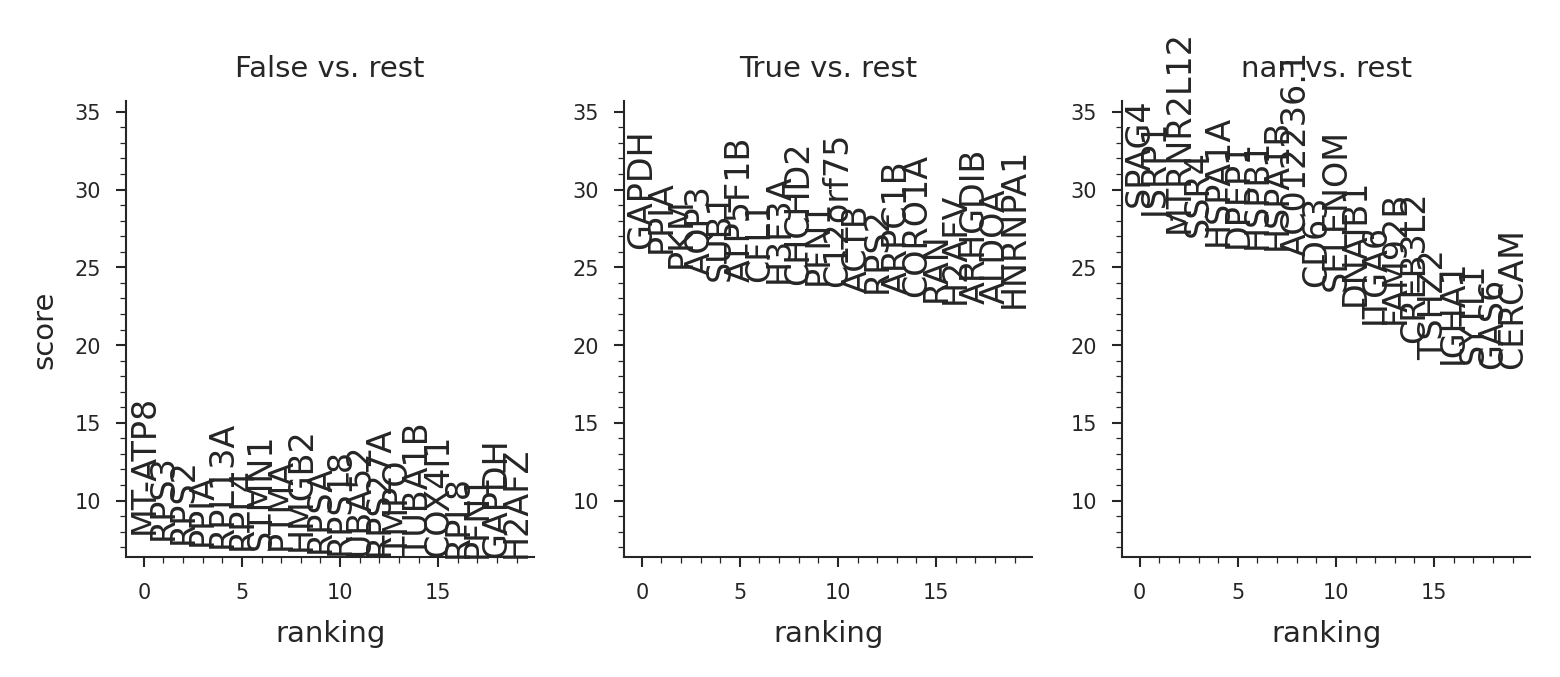

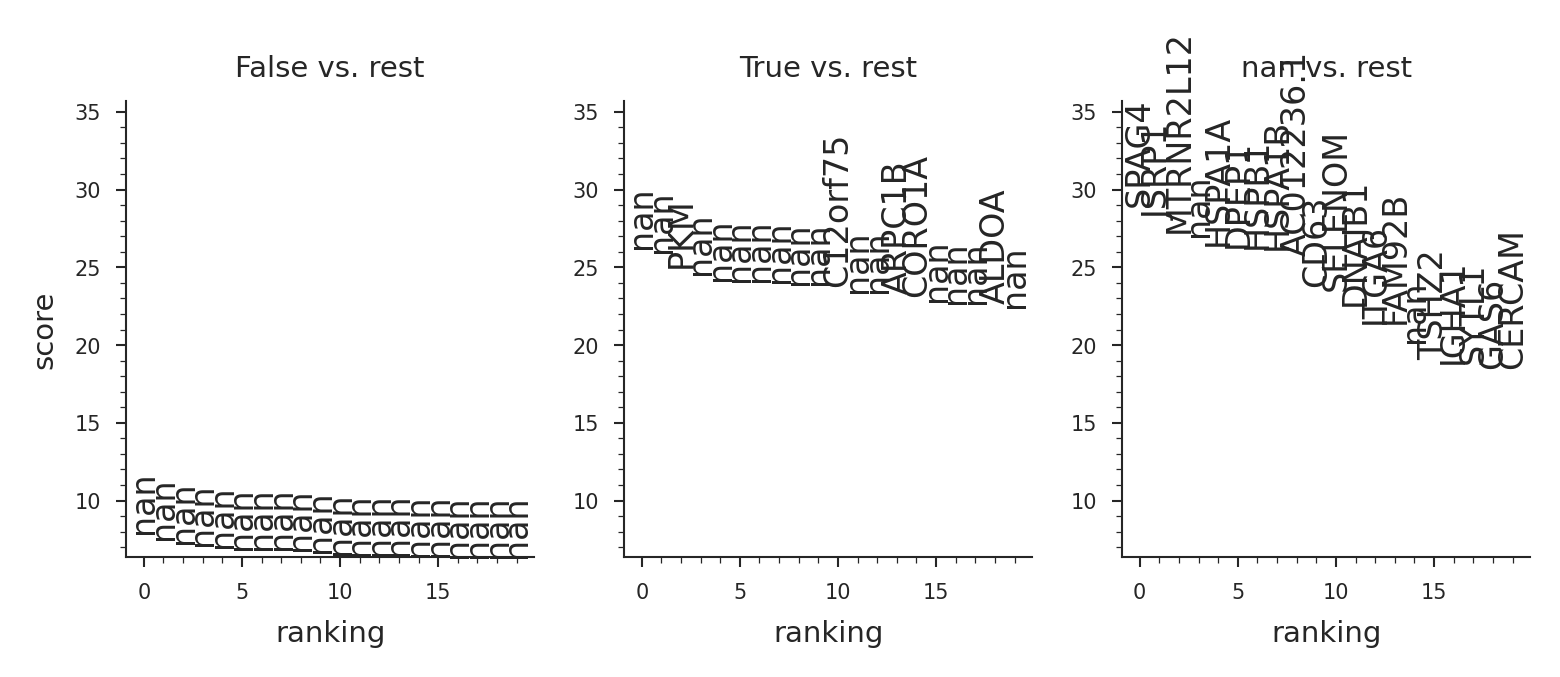

/home/michaelswift/miniconda3/envs/scanpy_new/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


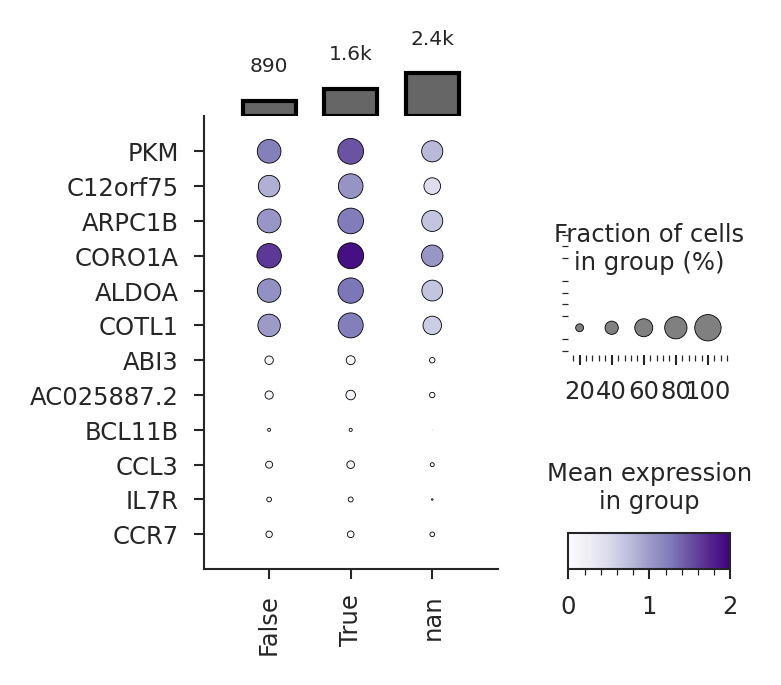

9204 cells
9204 cells after removing nans in shared

 LN_LN 
 LN_only 






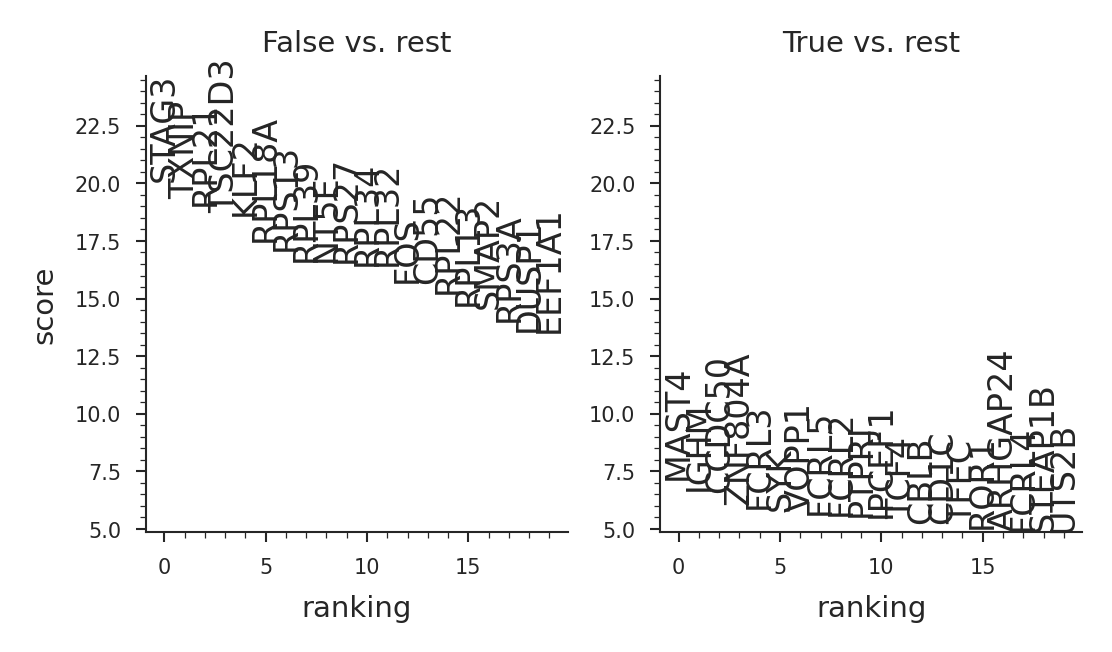

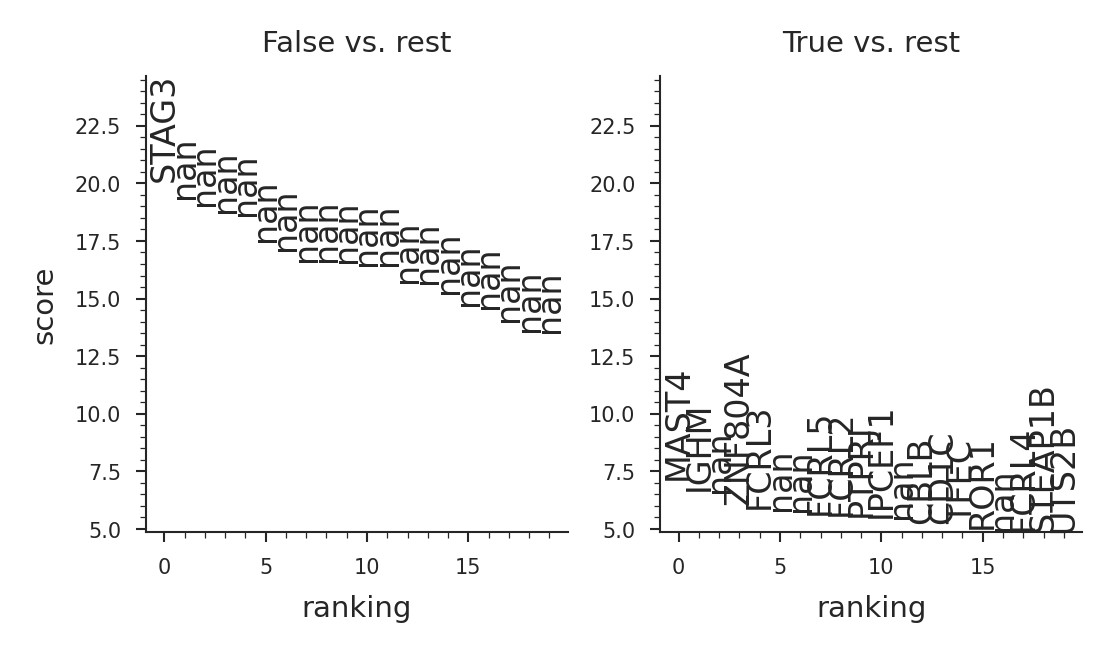

/home/michaelswift/miniconda3/envs/scanpy_new/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


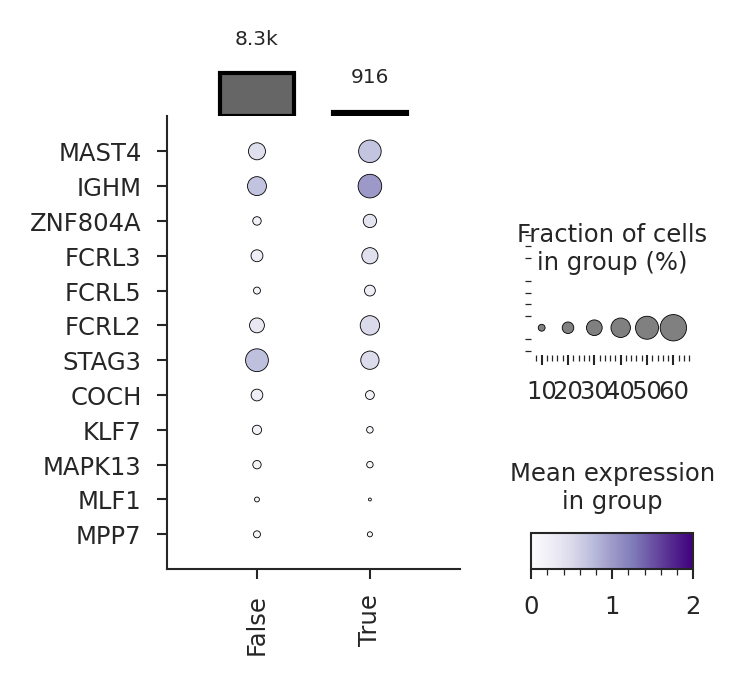

12710 cells
12710 cells after removing nans in shared

 LN_SP 
 mb_cells 






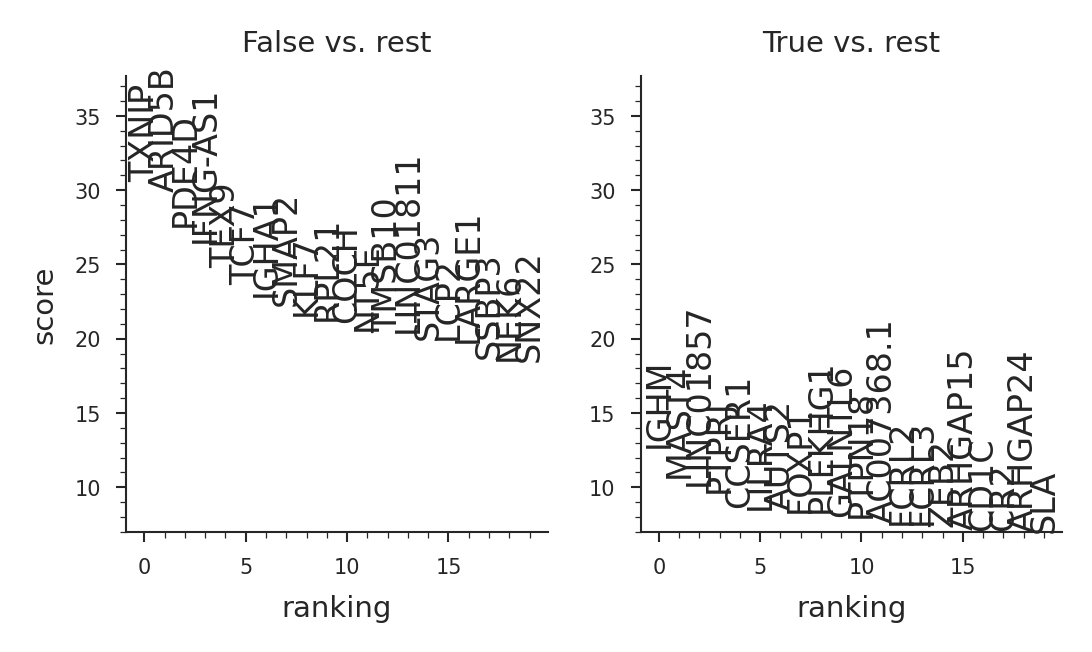

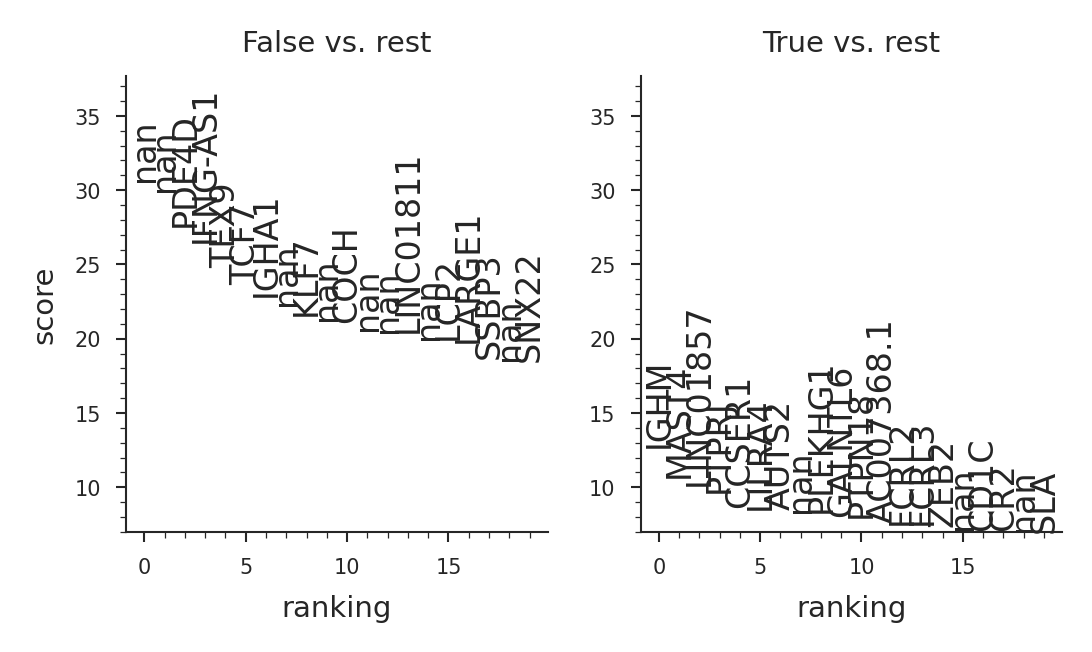

/home/michaelswift/miniconda3/envs/scanpy_new/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


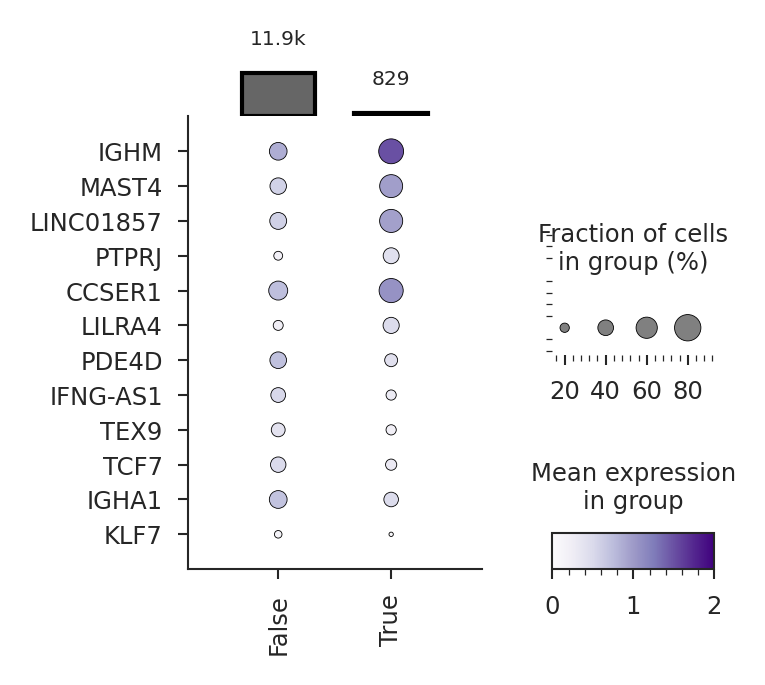

4908 cells
4908 cells after removing nans in shared

 LN_SP 
 as_cells 






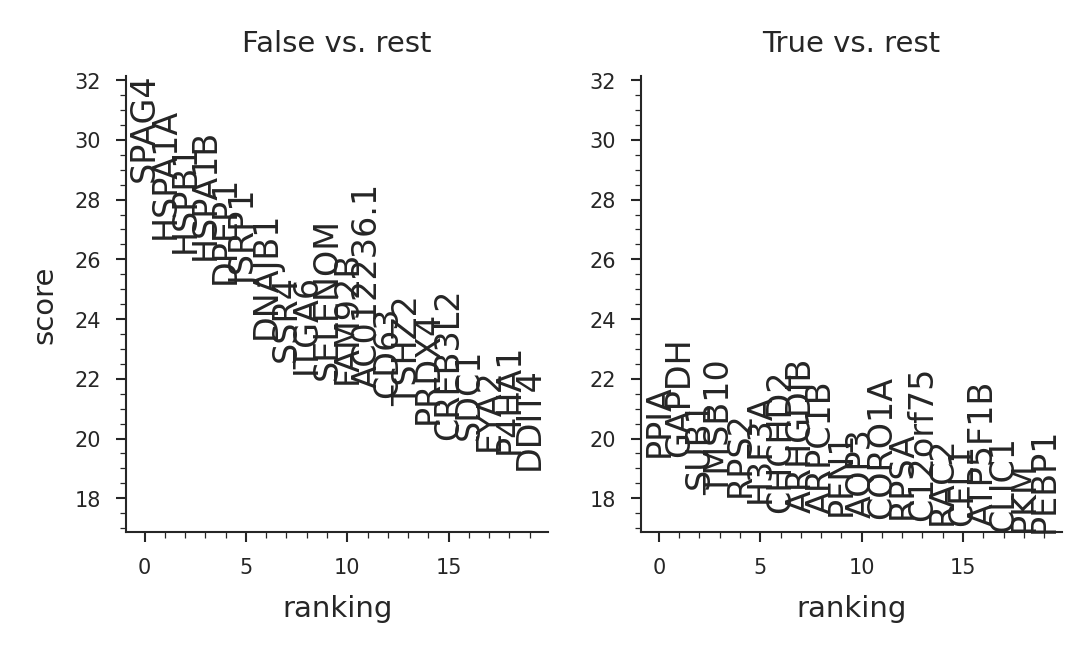

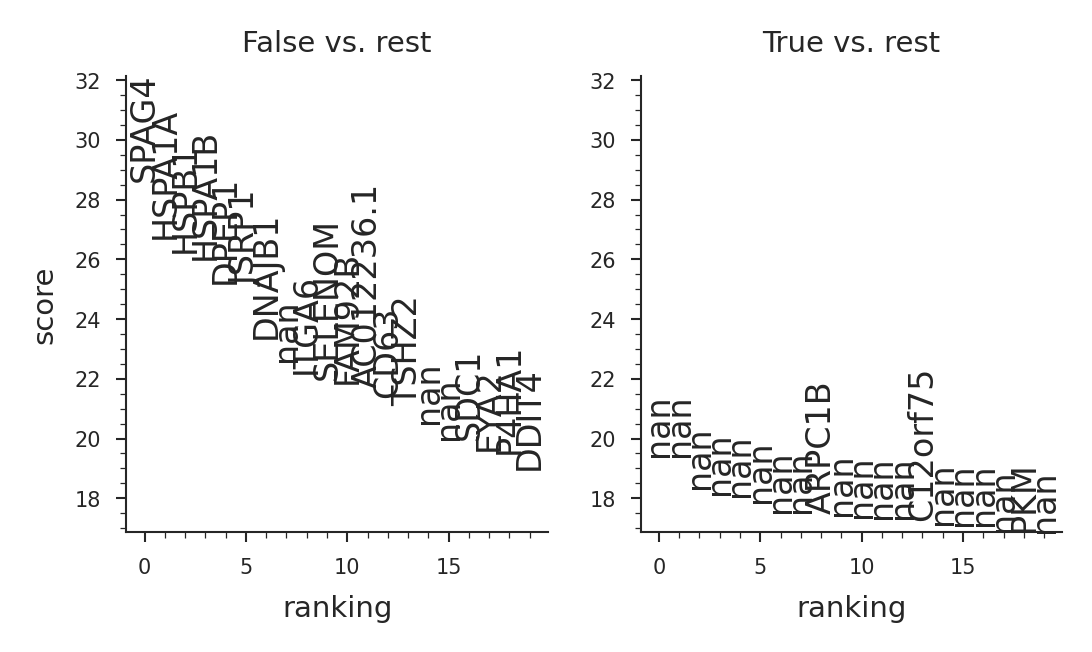

/home/michaelswift/miniconda3/envs/scanpy_new/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


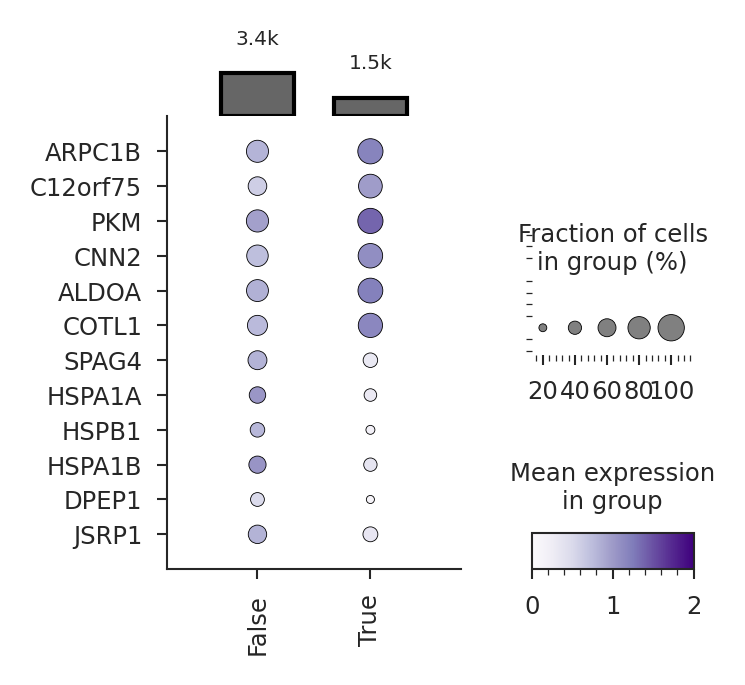

9204 cells
9204 cells after removing nans in shared

 LN_SP 
 LN_only 






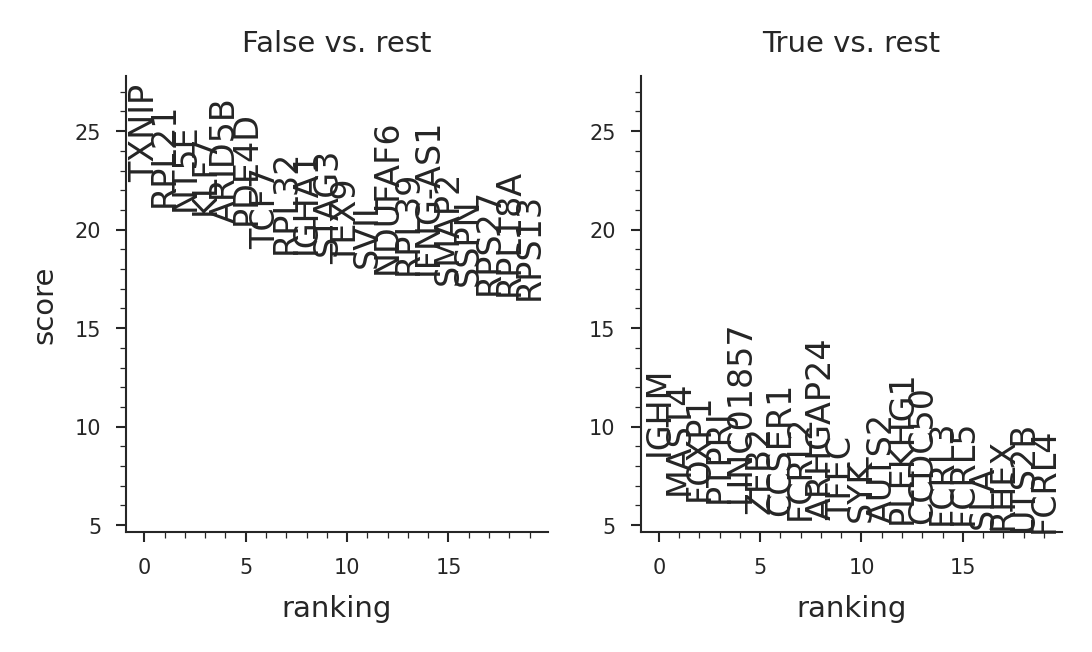

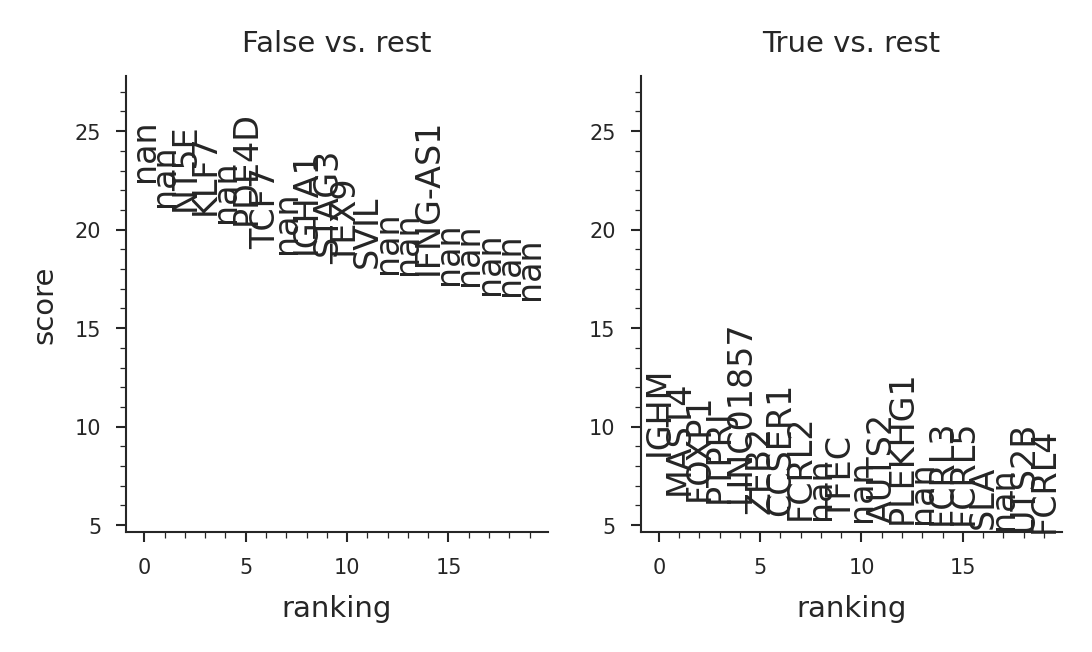

/home/michaelswift/miniconda3/envs/scanpy_new/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


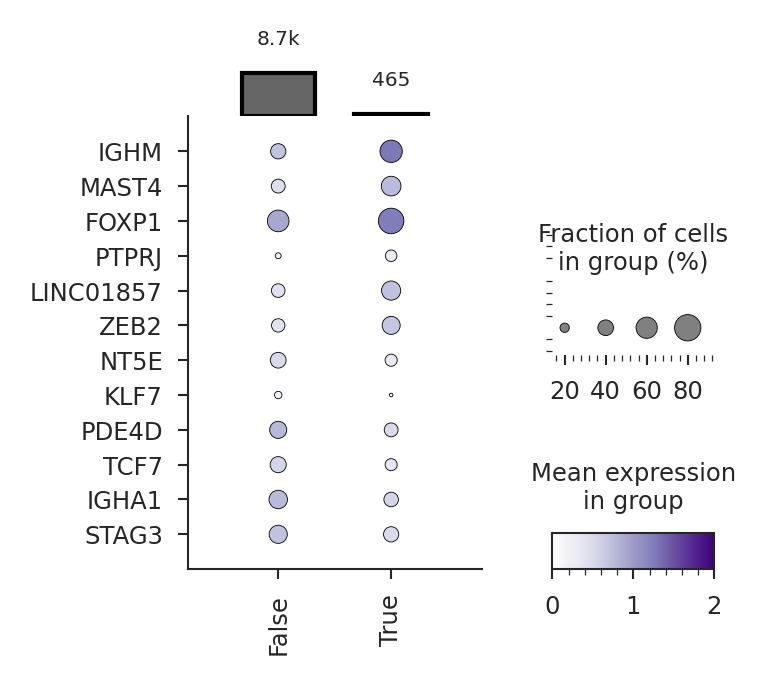

12710 cells
12710 cells after removing nans in shared

 LN_PB 
 mb_cells 






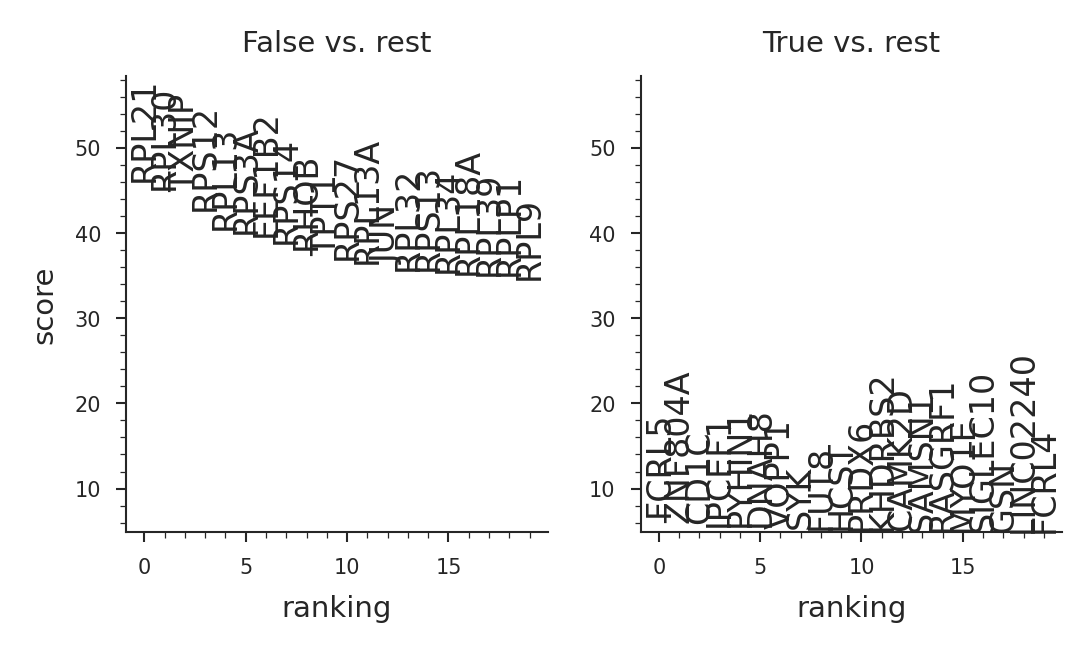

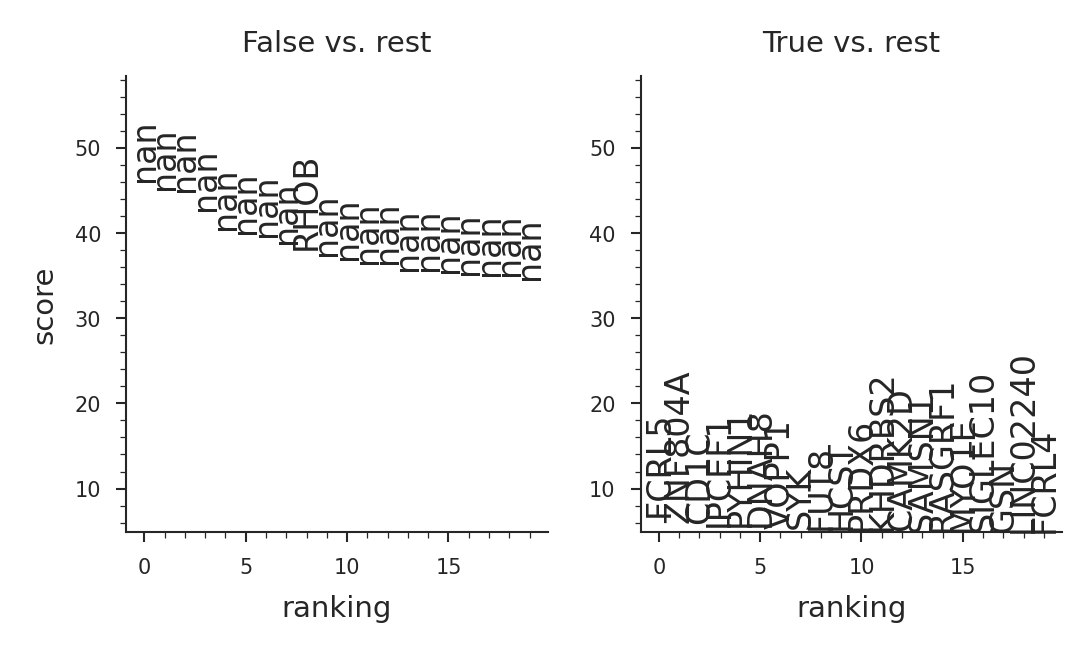

/home/michaelswift/miniconda3/envs/scanpy_new/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


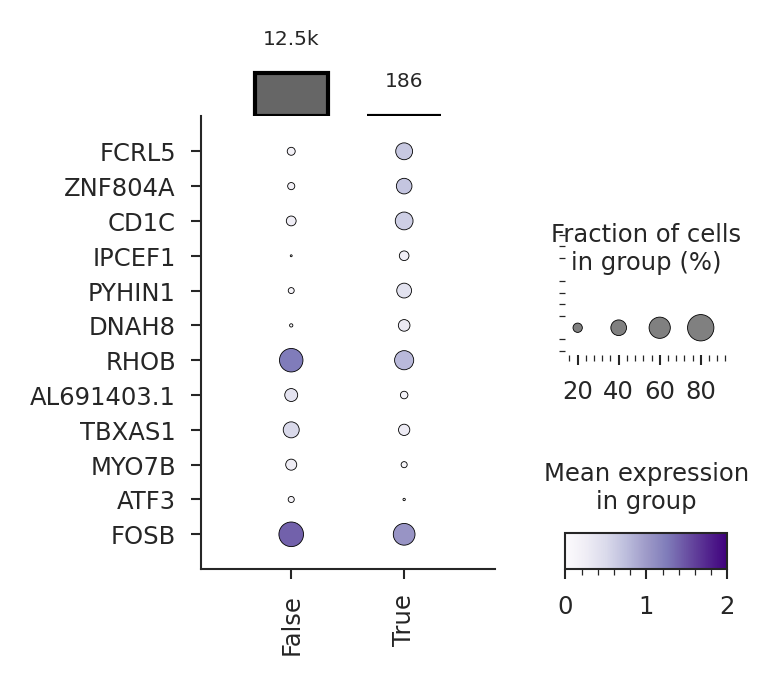

4908 cells
4908 cells after removing nans in shared

 LN_PB 
 as_cells 






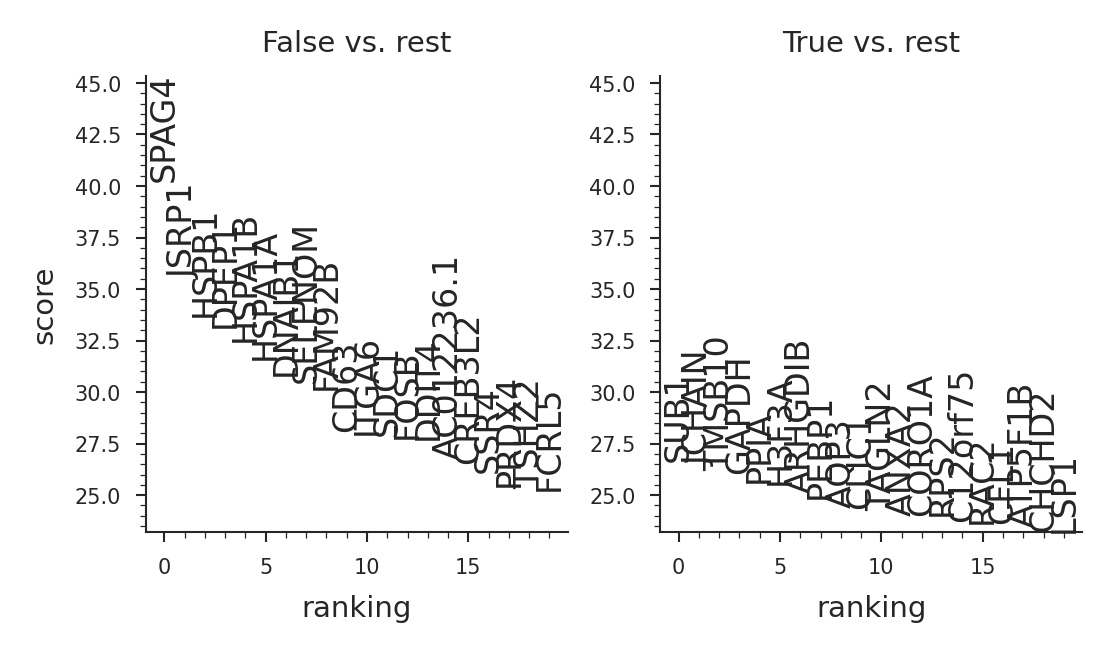

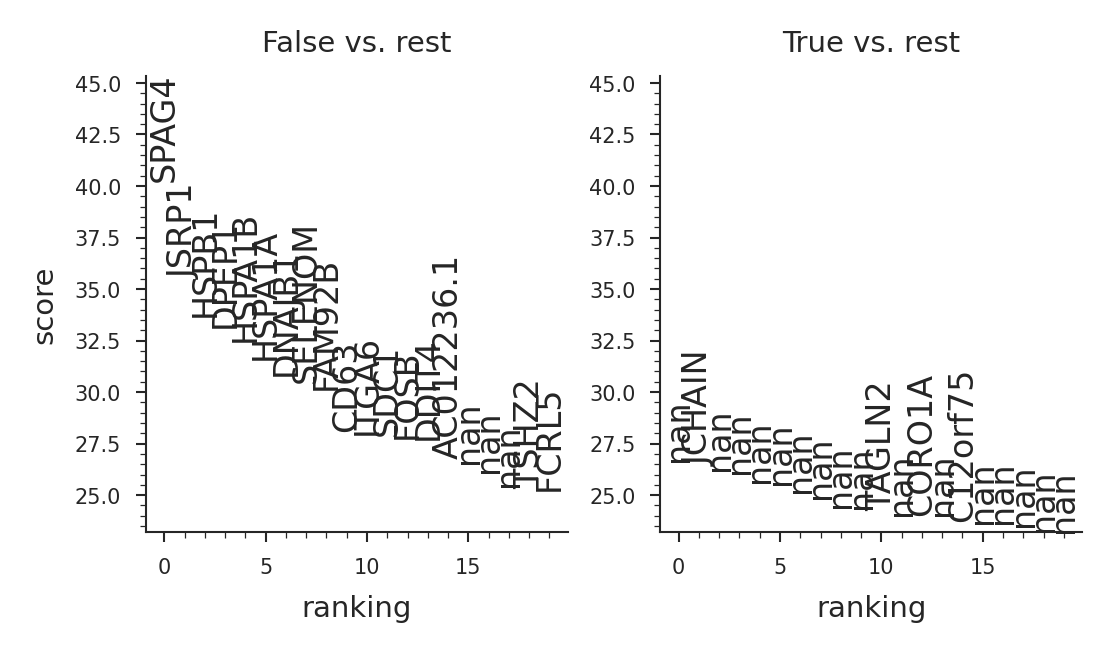

/home/michaelswift/miniconda3/envs/scanpy_new/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


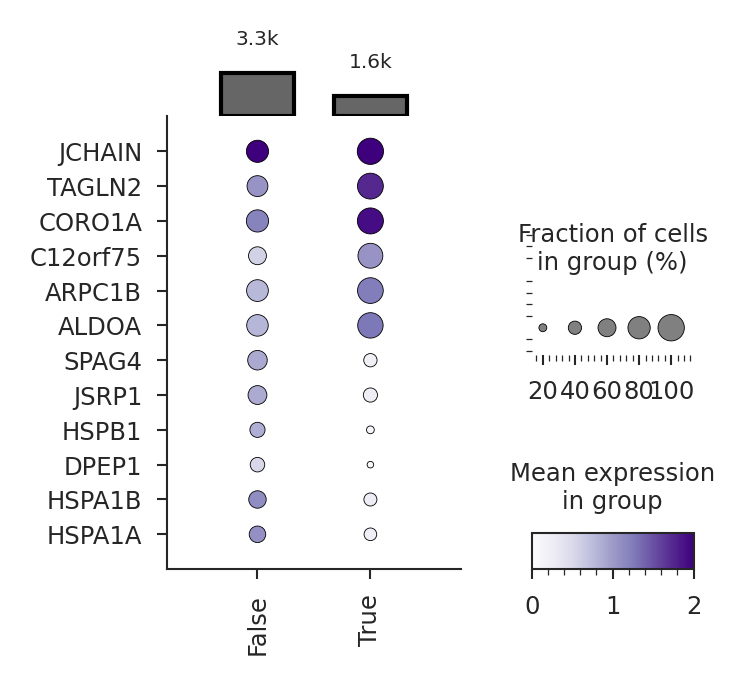

9204 cells
9204 cells after removing nans in shared

 LN_PB 
 LN_only 






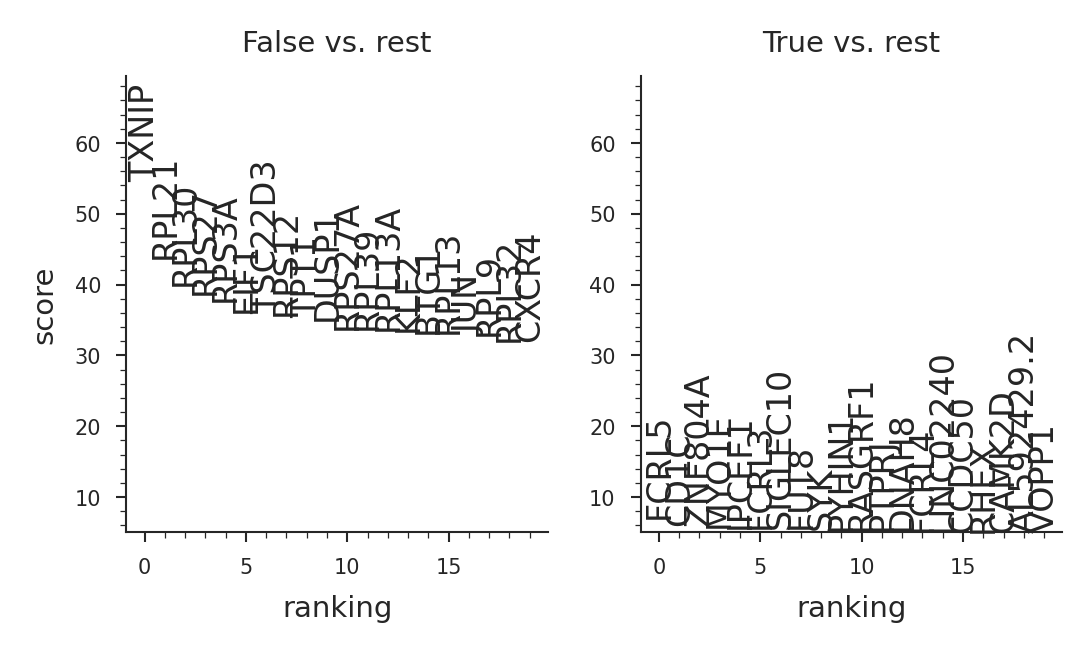

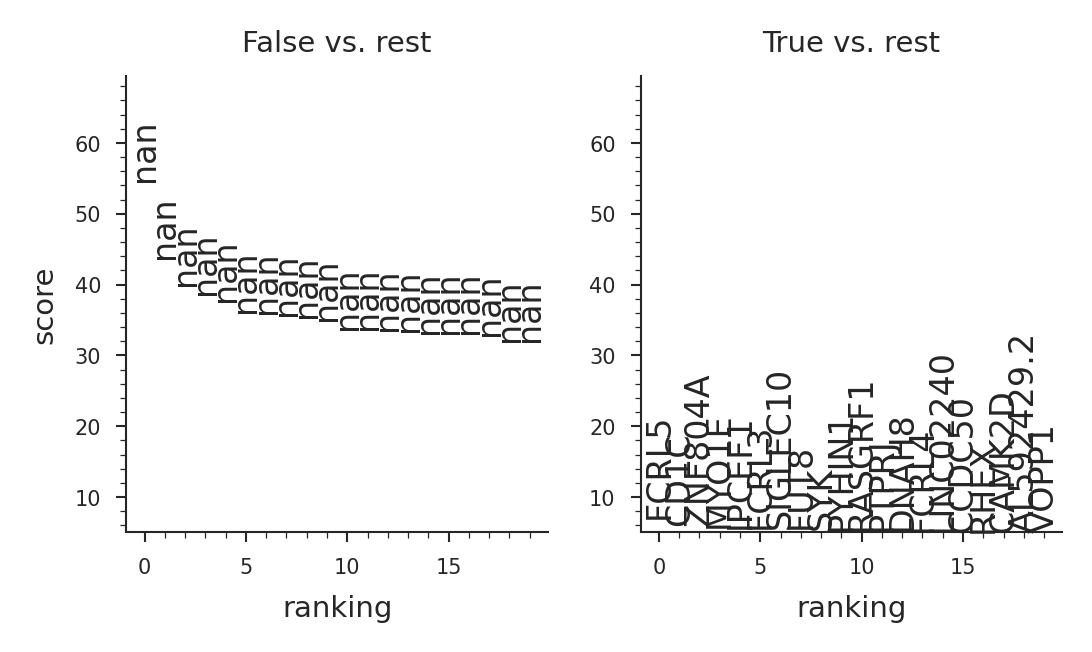

/home/michaelswift/miniconda3/envs/scanpy_new/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


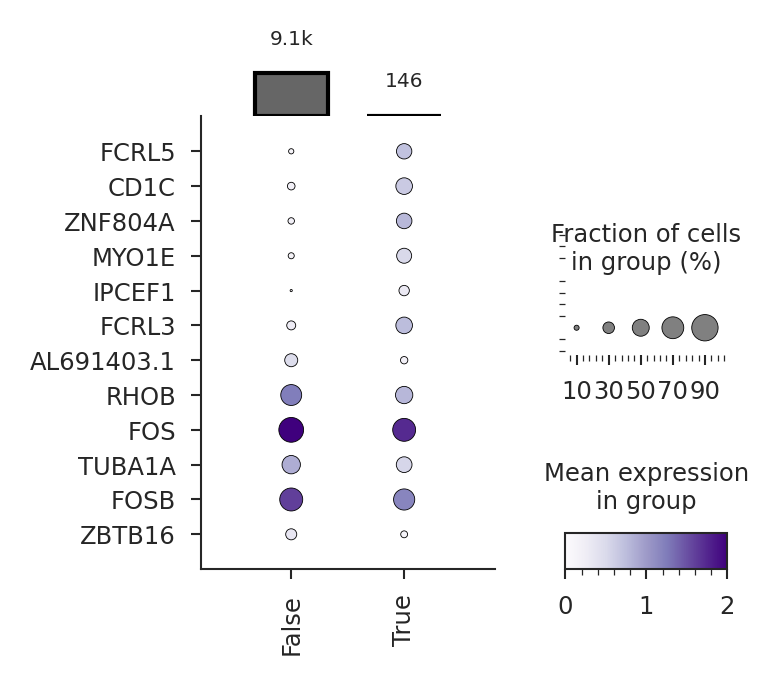

12710 cells
12710 cells after removing nans in shared

 BM_PB 
 mb_cells 






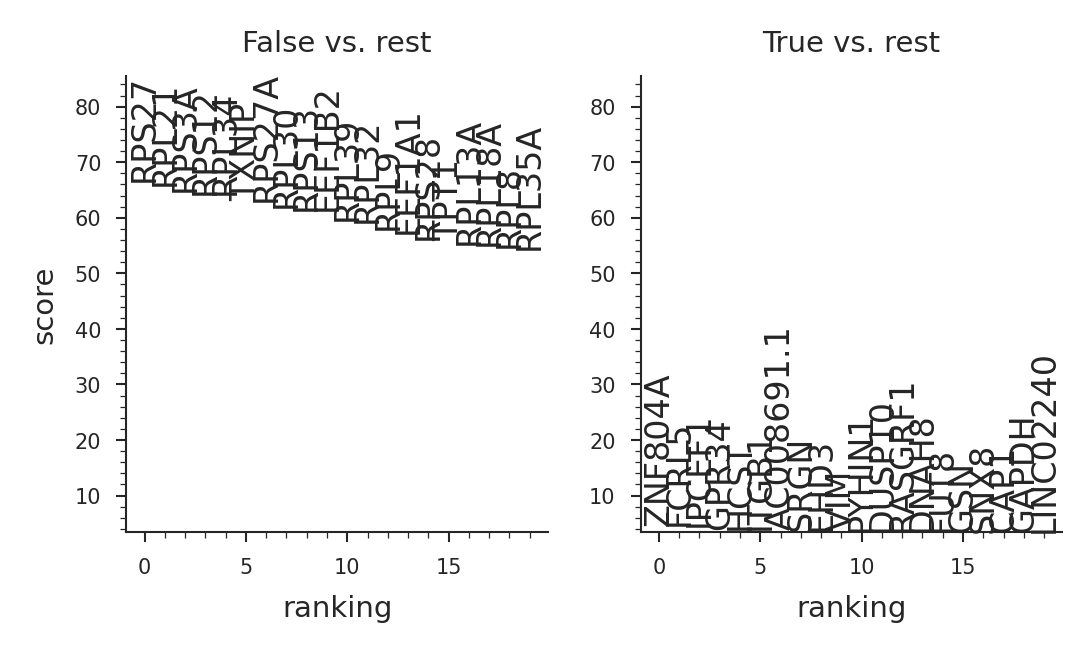

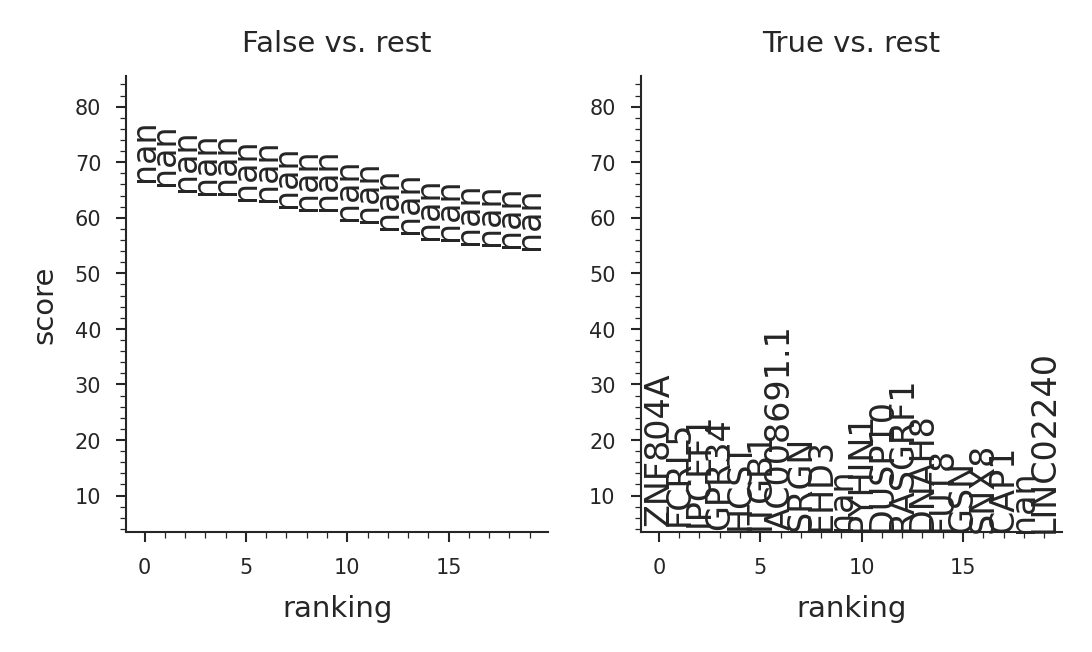

/home/michaelswift/miniconda3/envs/scanpy_new/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


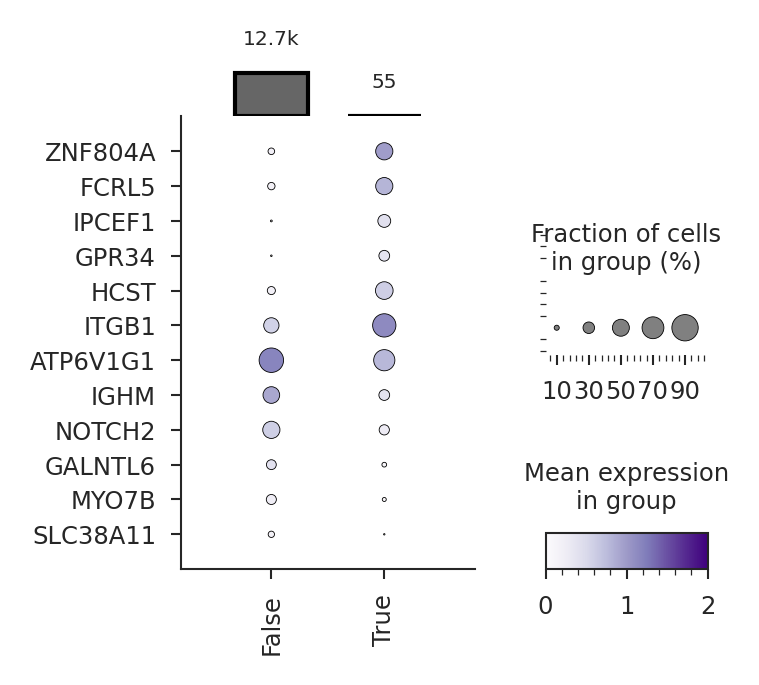

4908 cells
4908 cells after removing nans in shared

 BM_PB 
 as_cells 






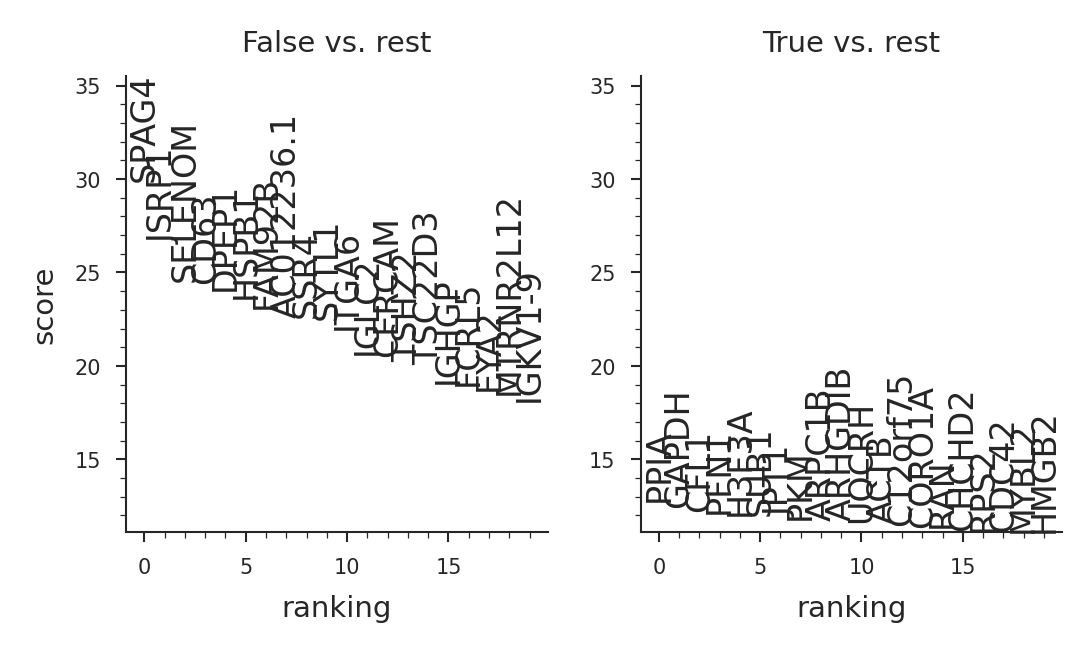

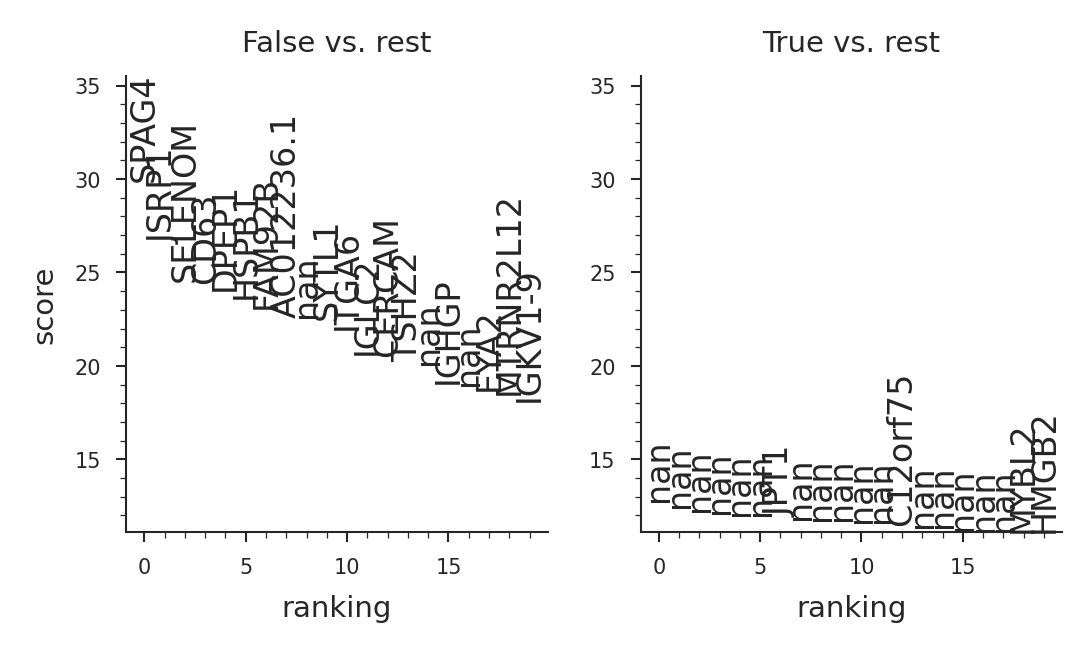

/home/michaelswift/miniconda3/envs/scanpy_new/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


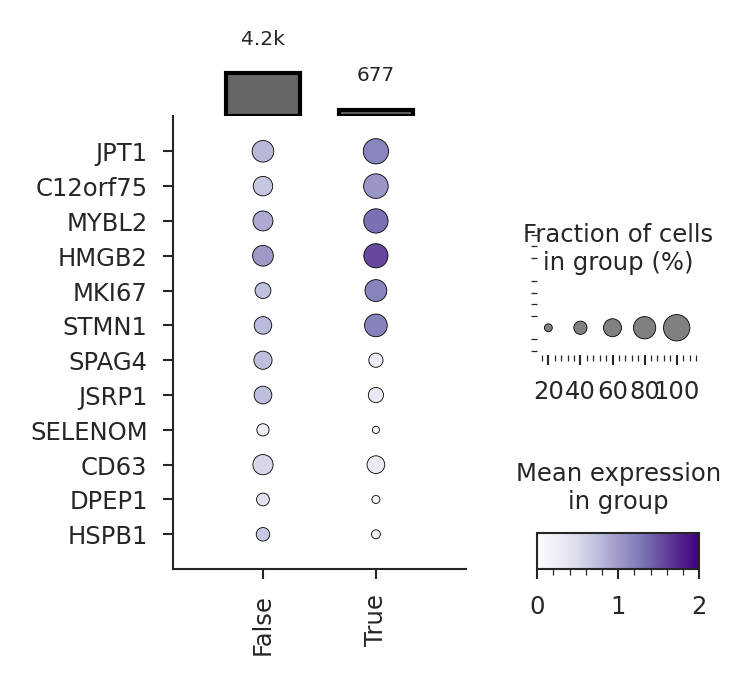

9204 cells
9204 cells after removing nans in shared

 BM_PB 
 LN_only 






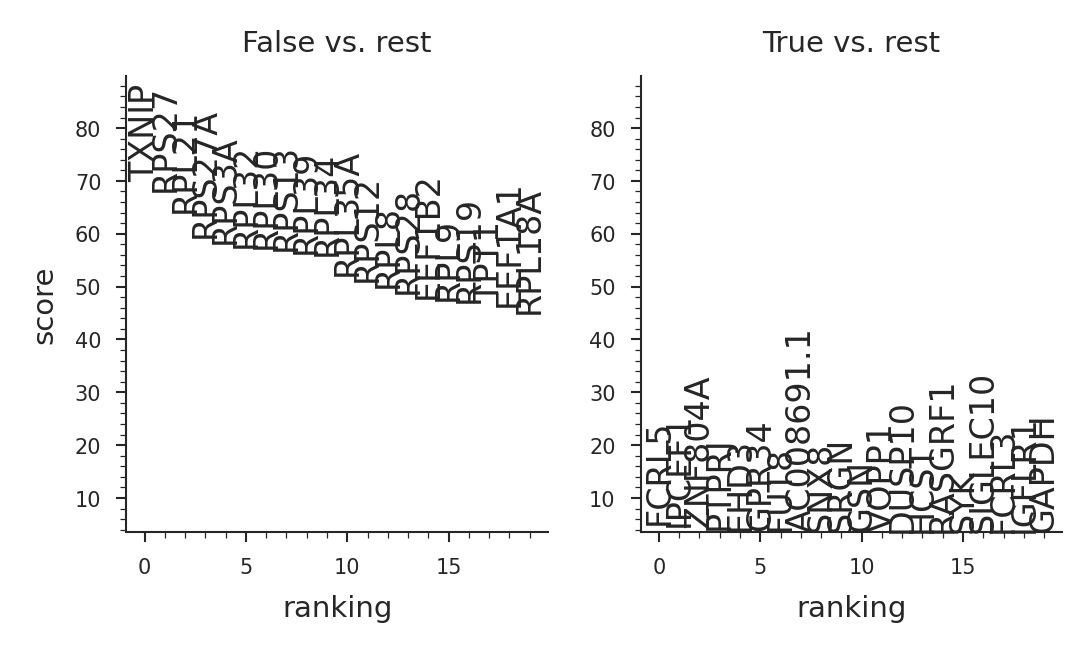

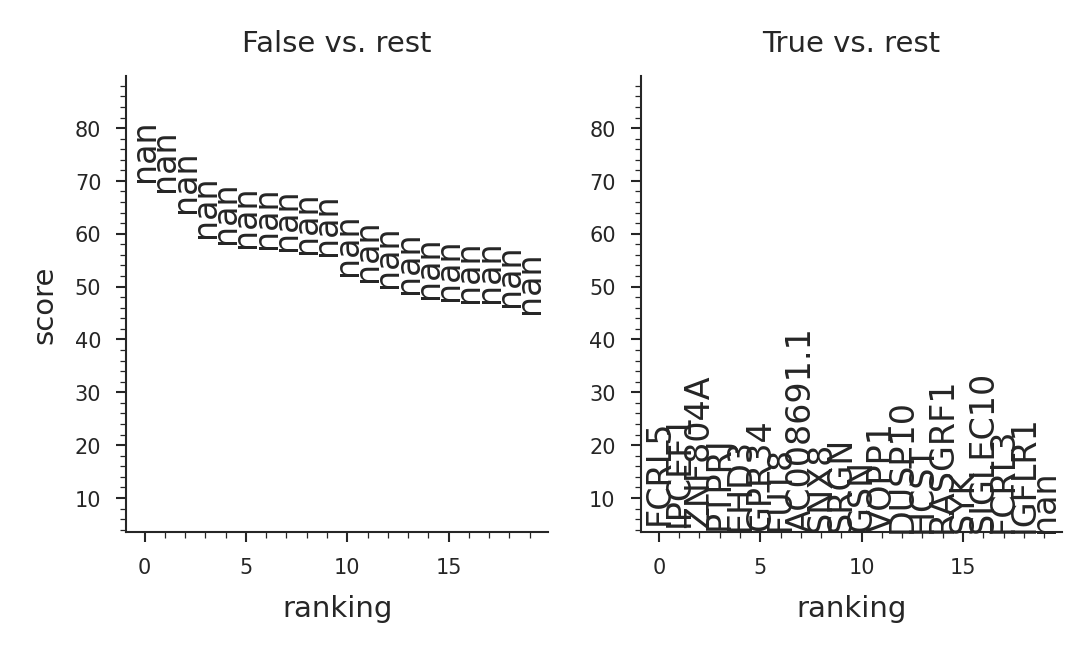

/home/michaelswift/miniconda3/envs/scanpy_new/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


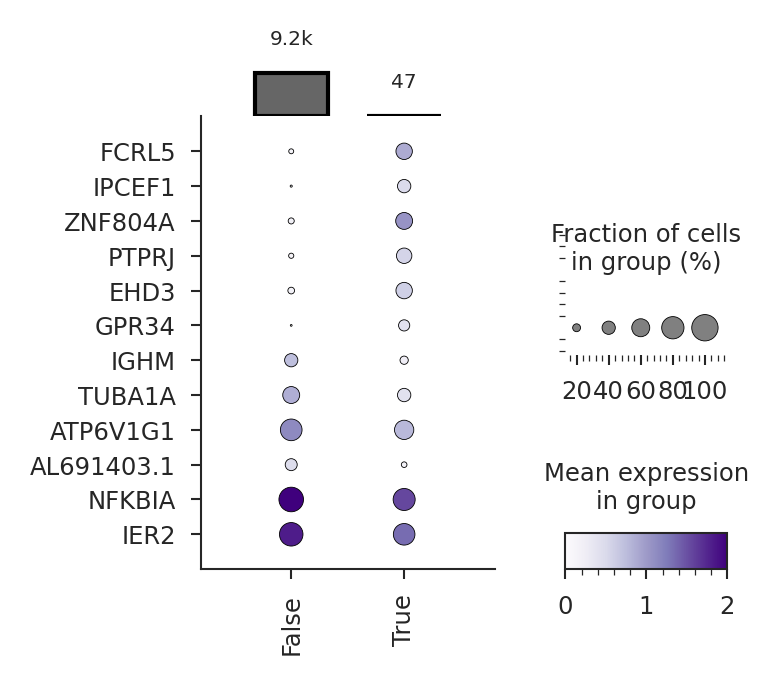

12710 cells
12710 cells after removing nans in shared

 SP_PB 
 mb_cells 






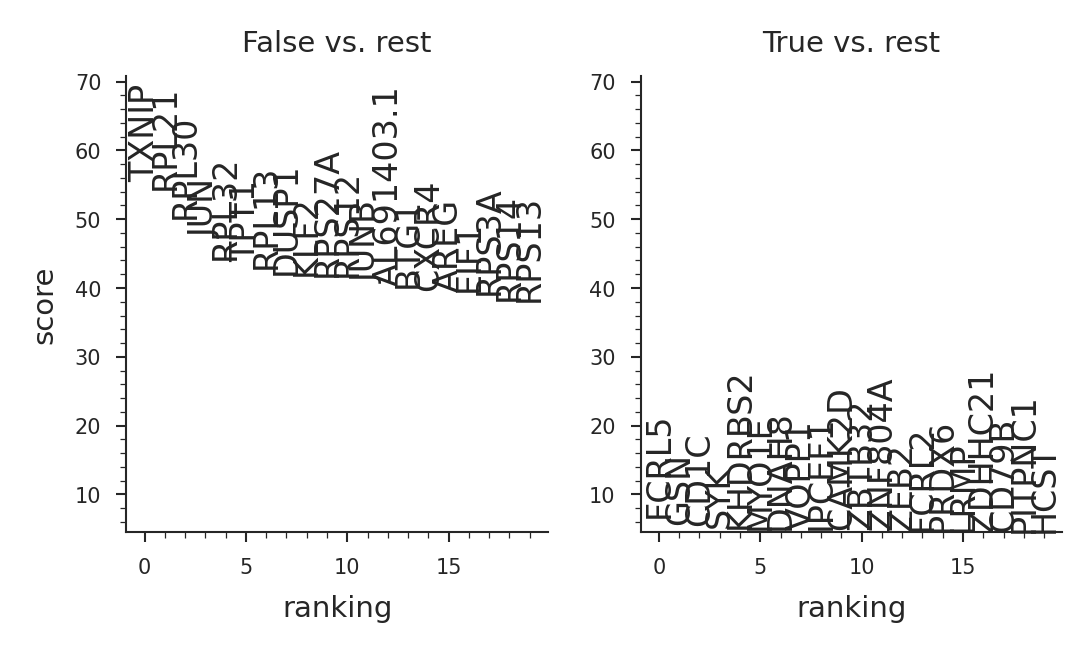

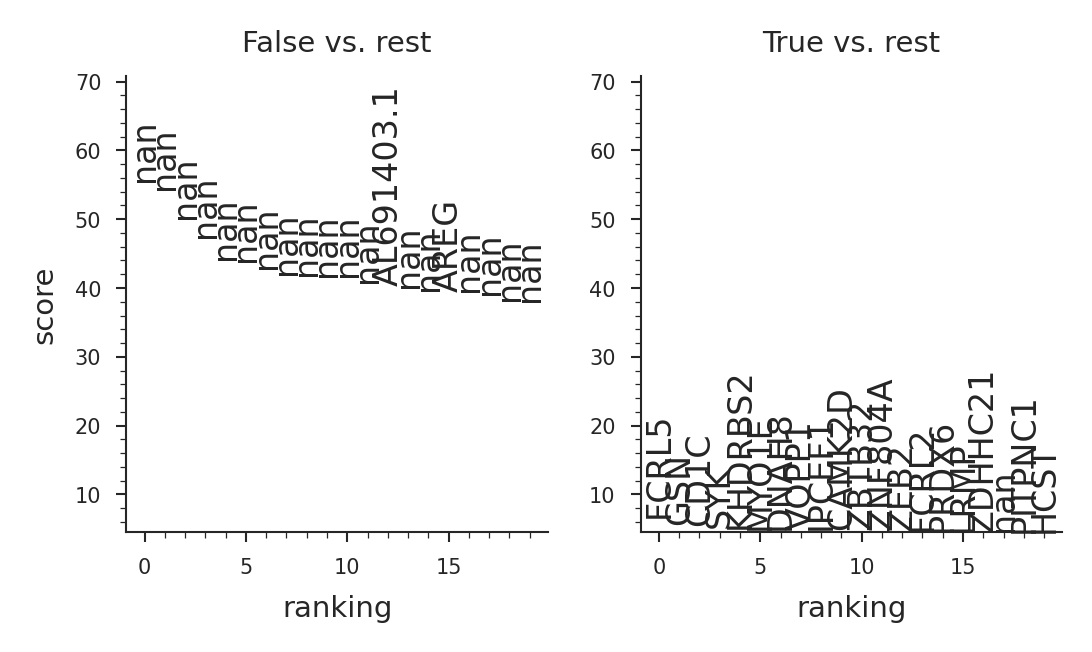

/home/michaelswift/miniconda3/envs/scanpy_new/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


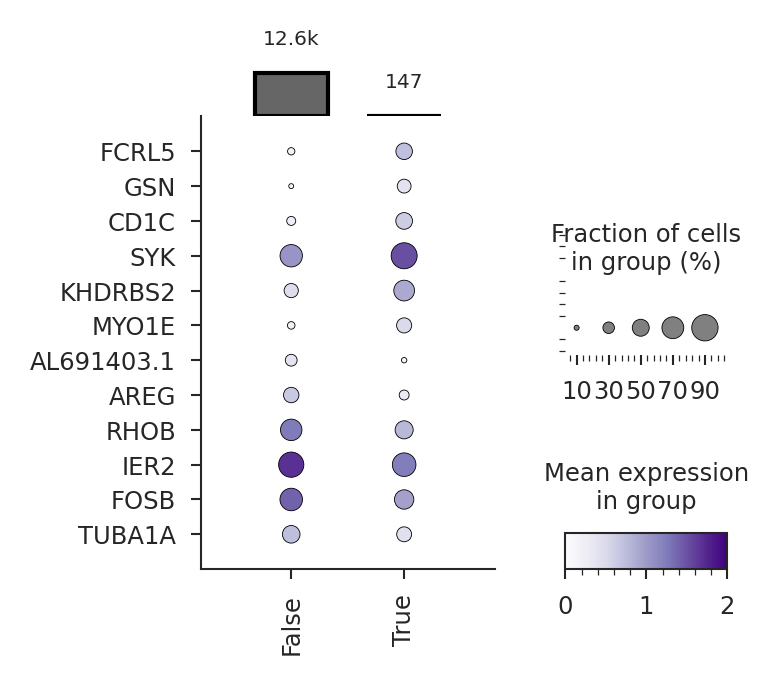

4908 cells
4908 cells after removing nans in shared

 SP_PB 
 as_cells 






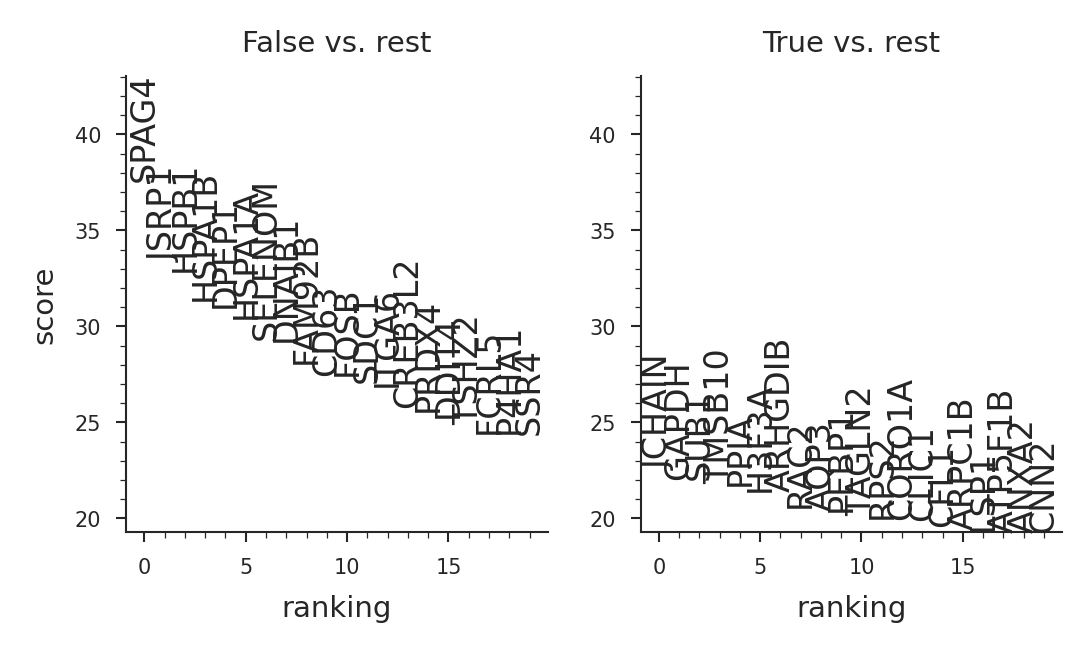

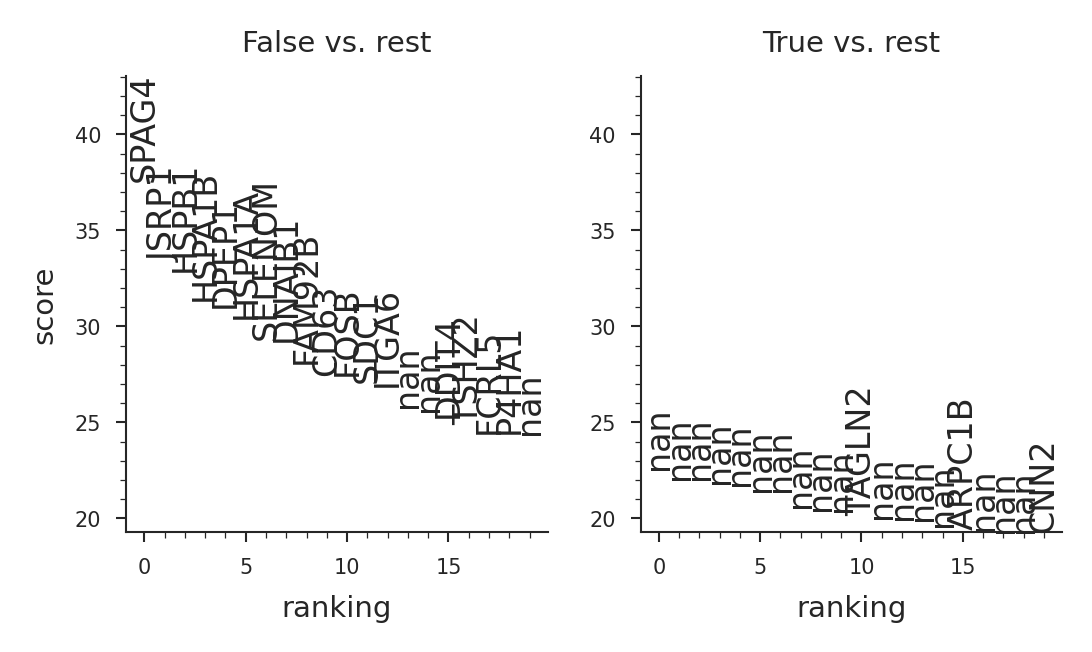

/home/michaelswift/miniconda3/envs/scanpy_new/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


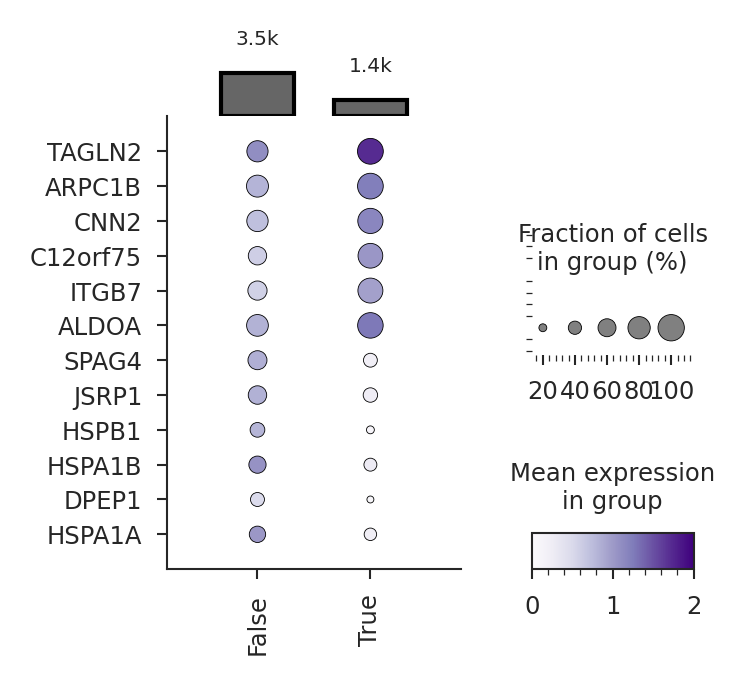

9204 cells
9204 cells after removing nans in shared

 SP_PB 
 LN_only 






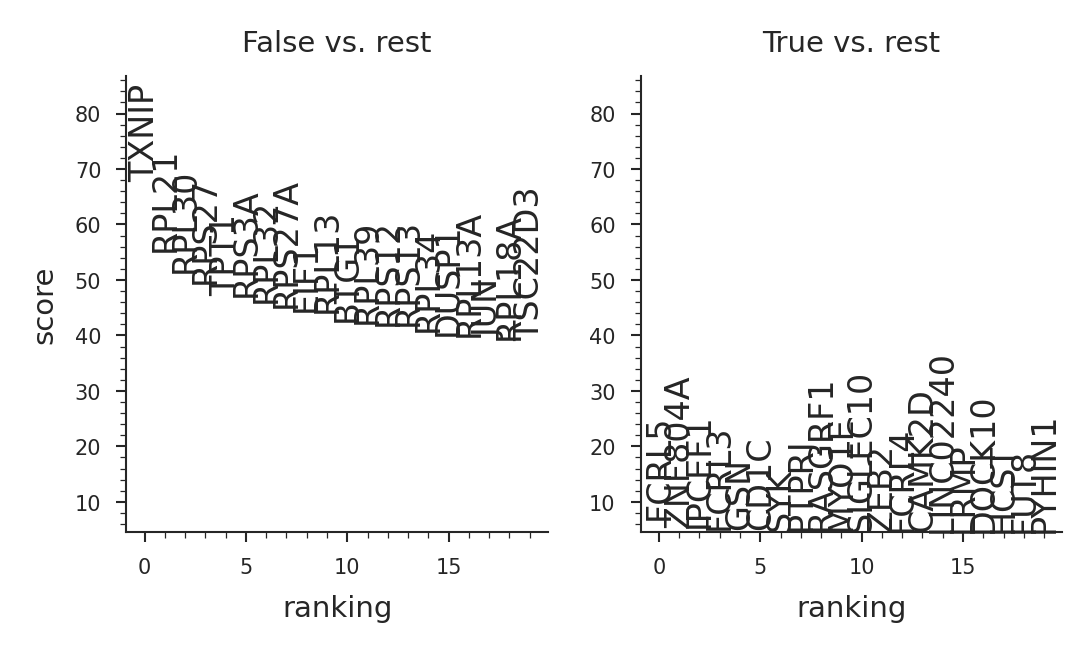

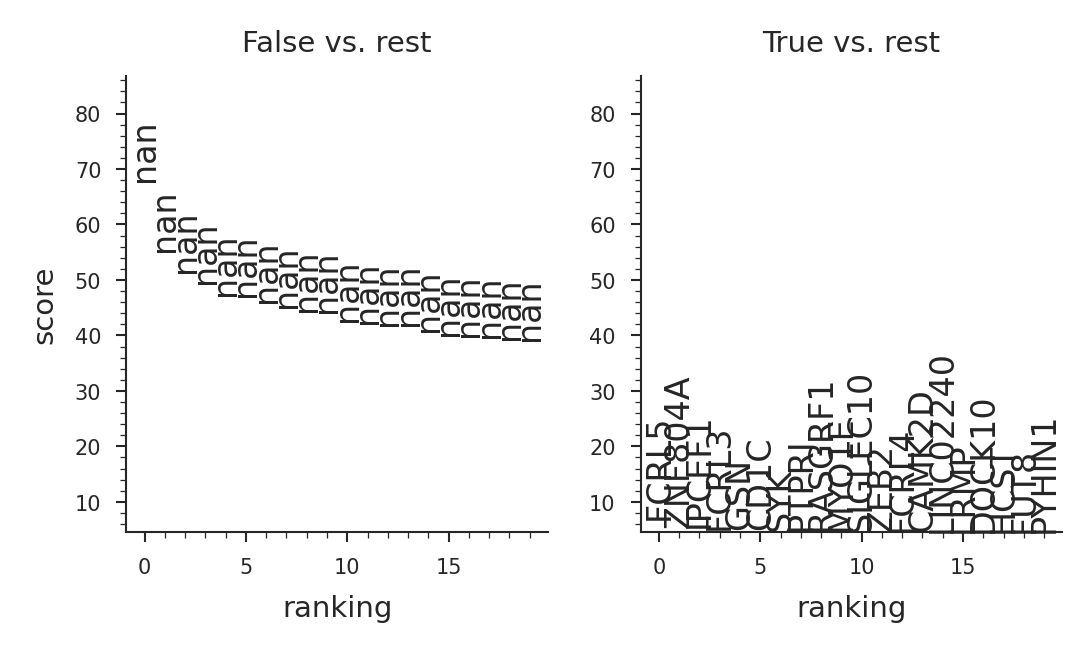

/home/michaelswift/miniconda3/envs/scanpy_new/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


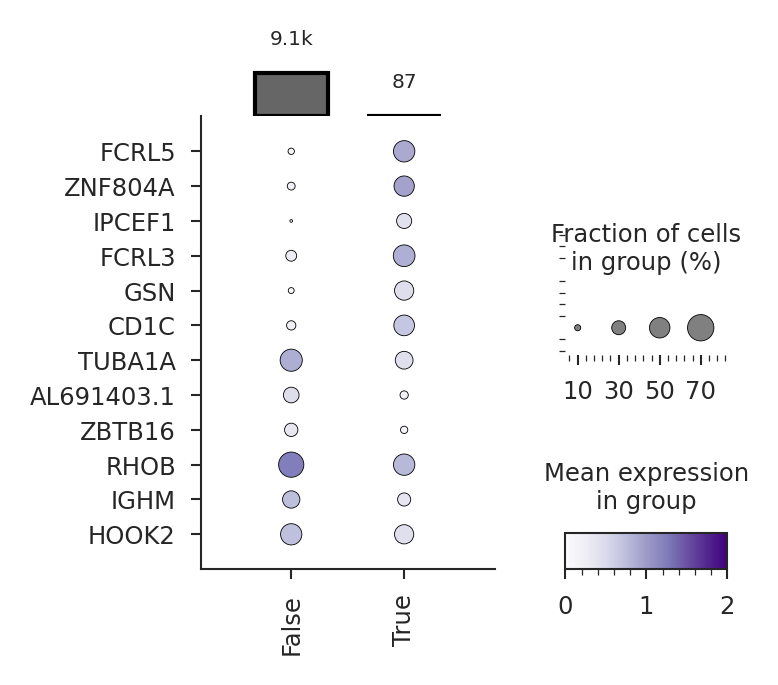

12710 cells
12710 cells after removing nans in shared

 SP_BM 
 mb_cells 






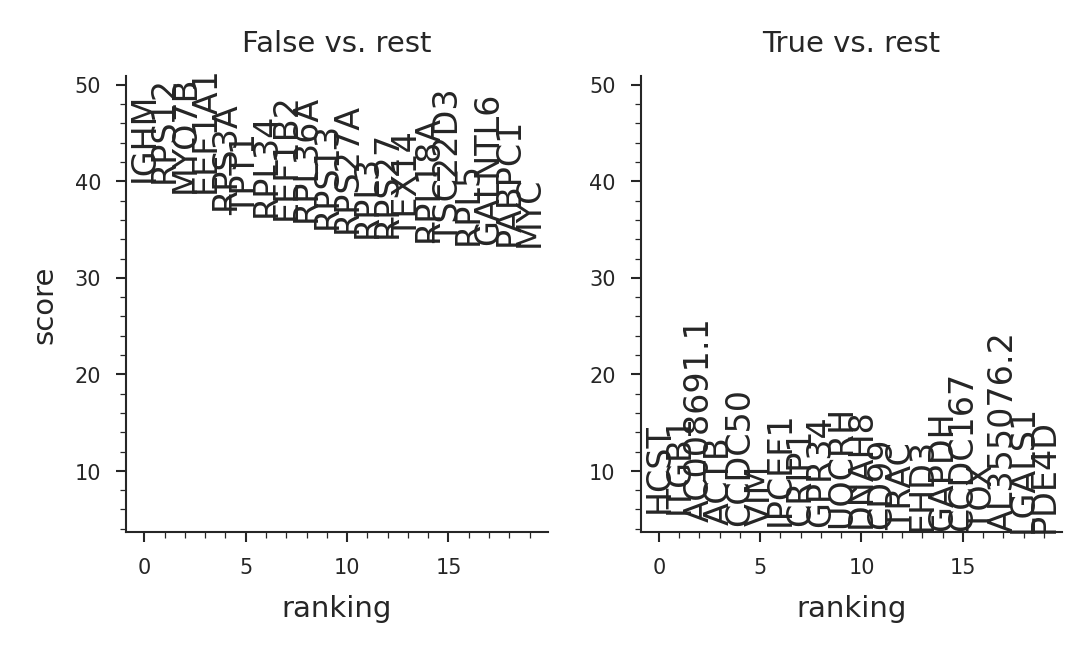

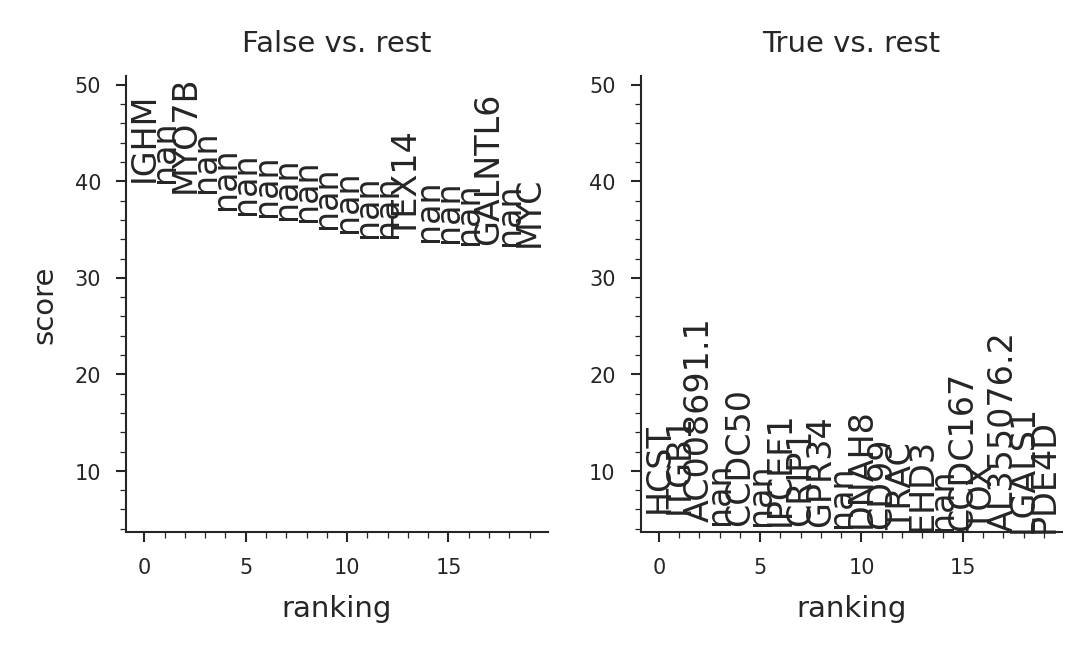

/home/michaelswift/miniconda3/envs/scanpy_new/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


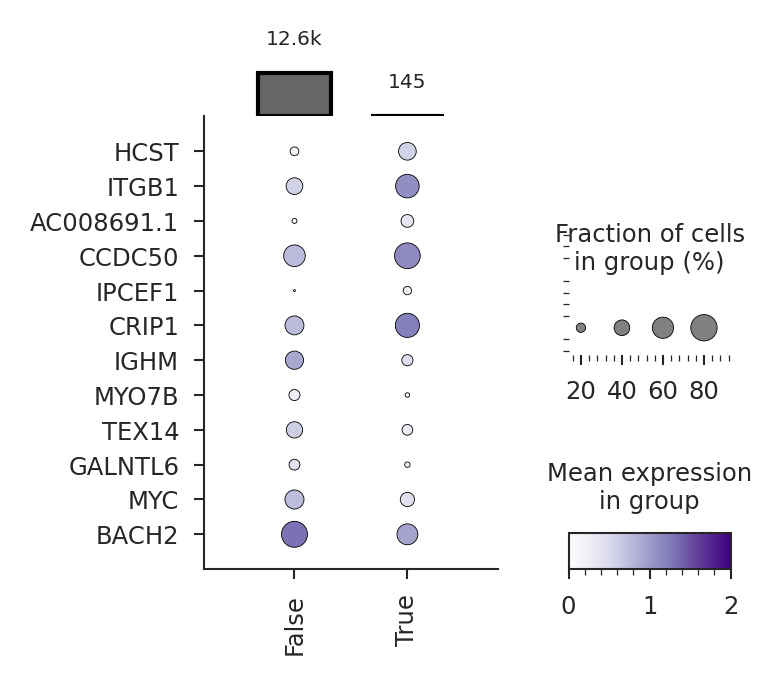

4908 cells
4908 cells after removing nans in shared

 SP_BM 
 as_cells 






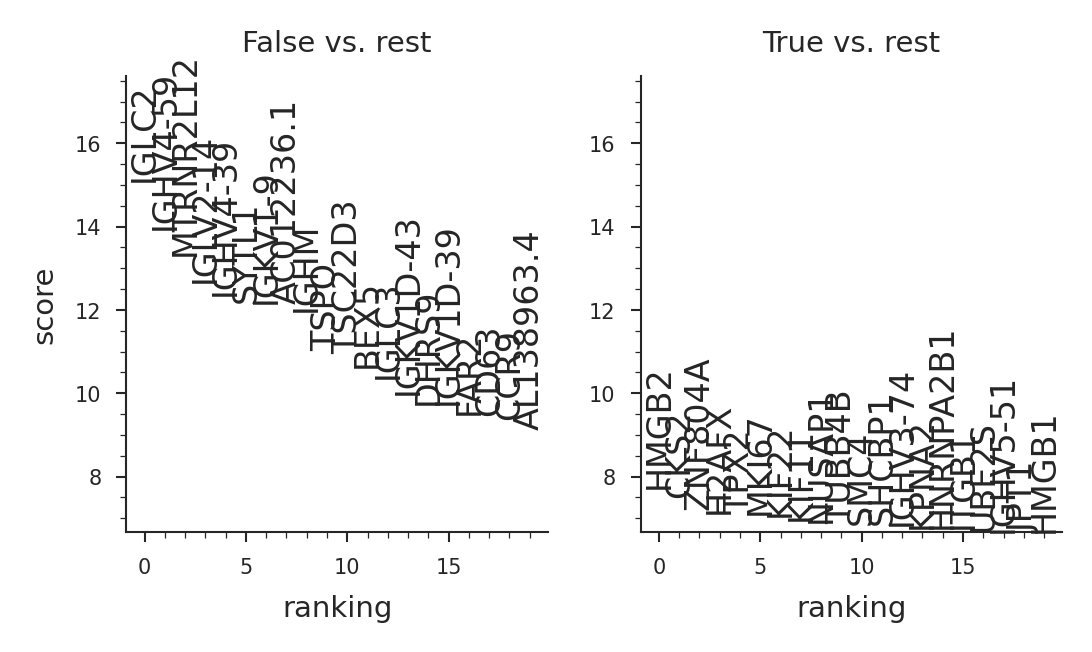

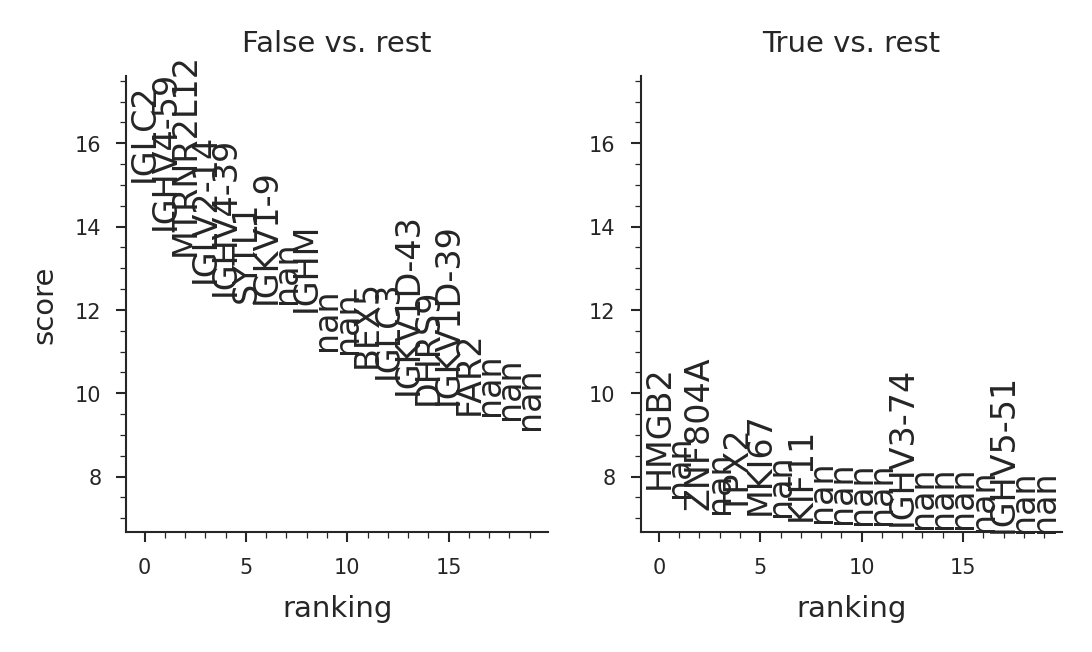

/home/michaelswift/miniconda3/envs/scanpy_new/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


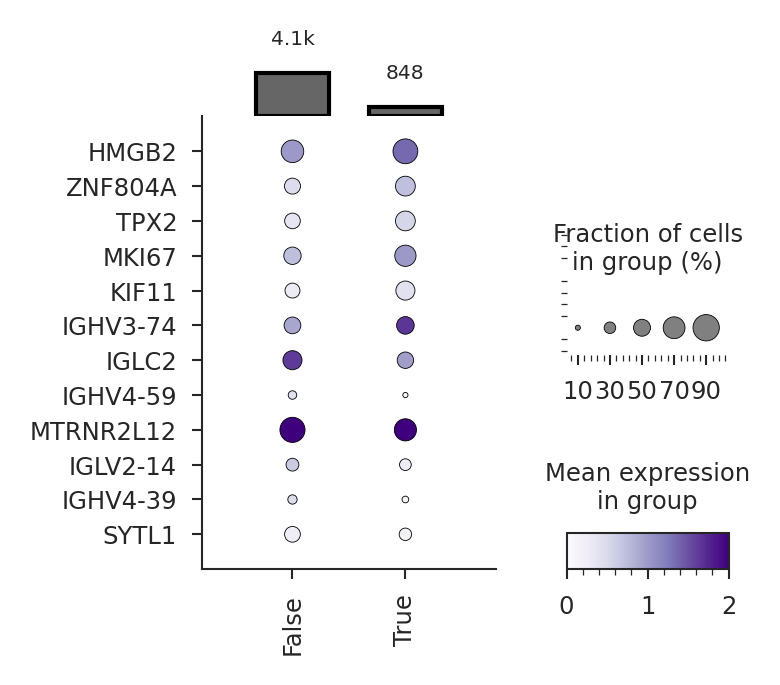

9204 cells
9204 cells after removing nans in shared

 SP_BM 
 LN_only 






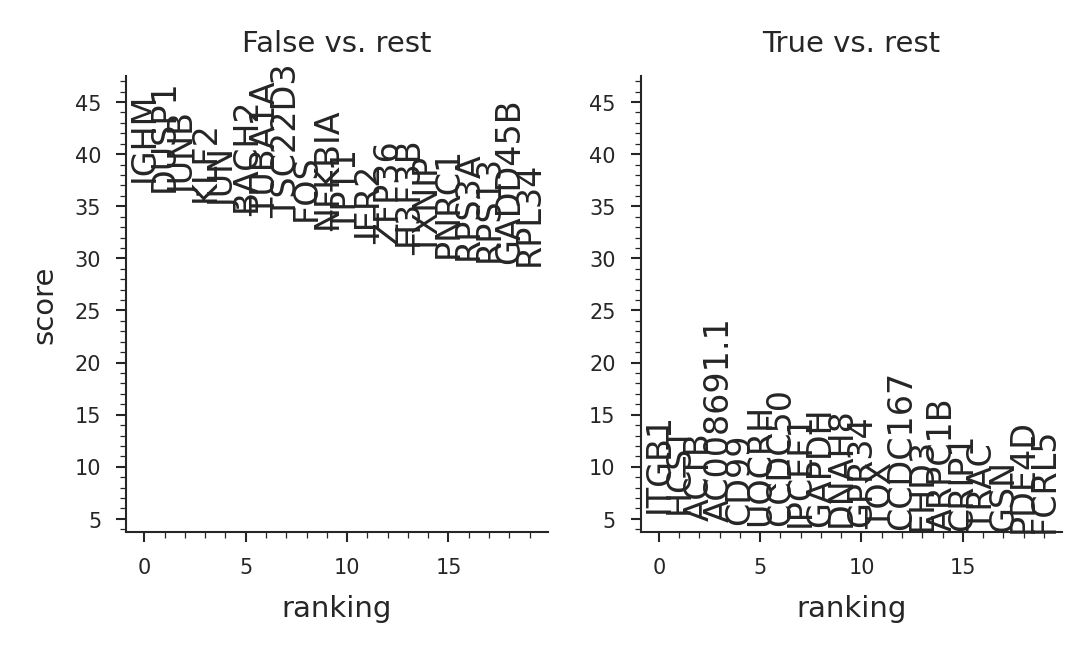

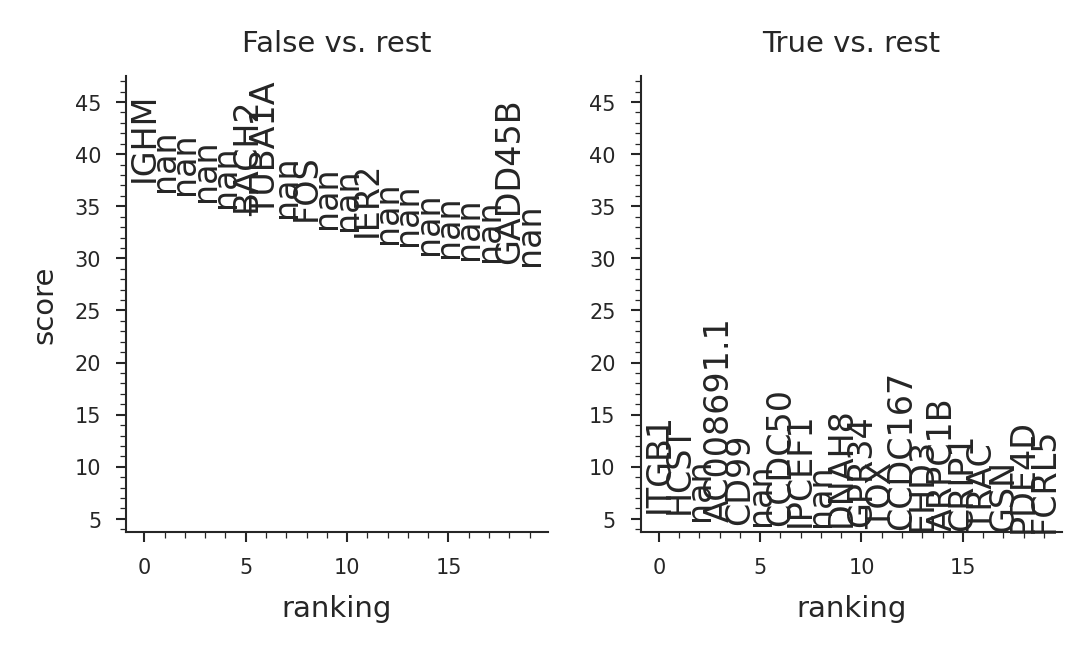

/home/michaelswift/miniconda3/envs/scanpy_new/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


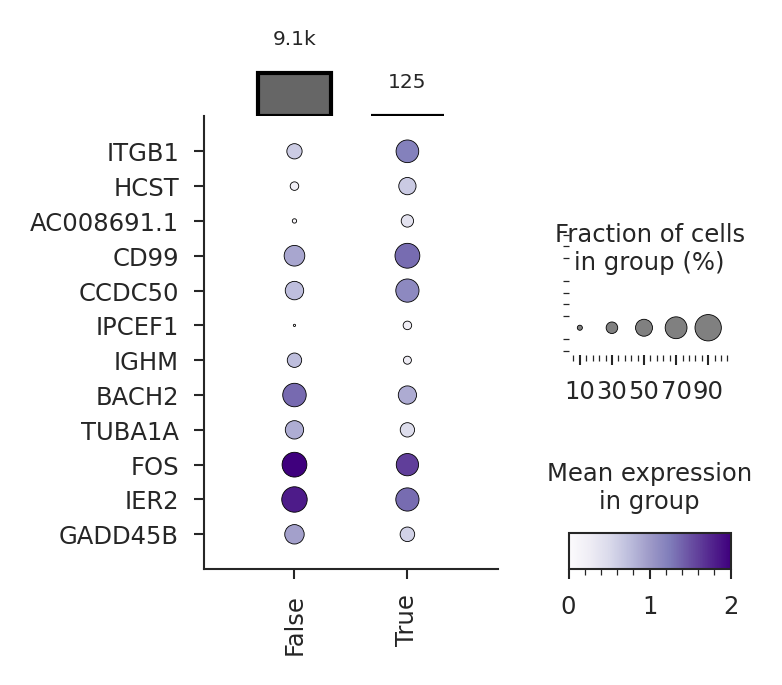

12710 cells
12710 cells after removing nans in shared

 LN_BM 
 mb_cells 






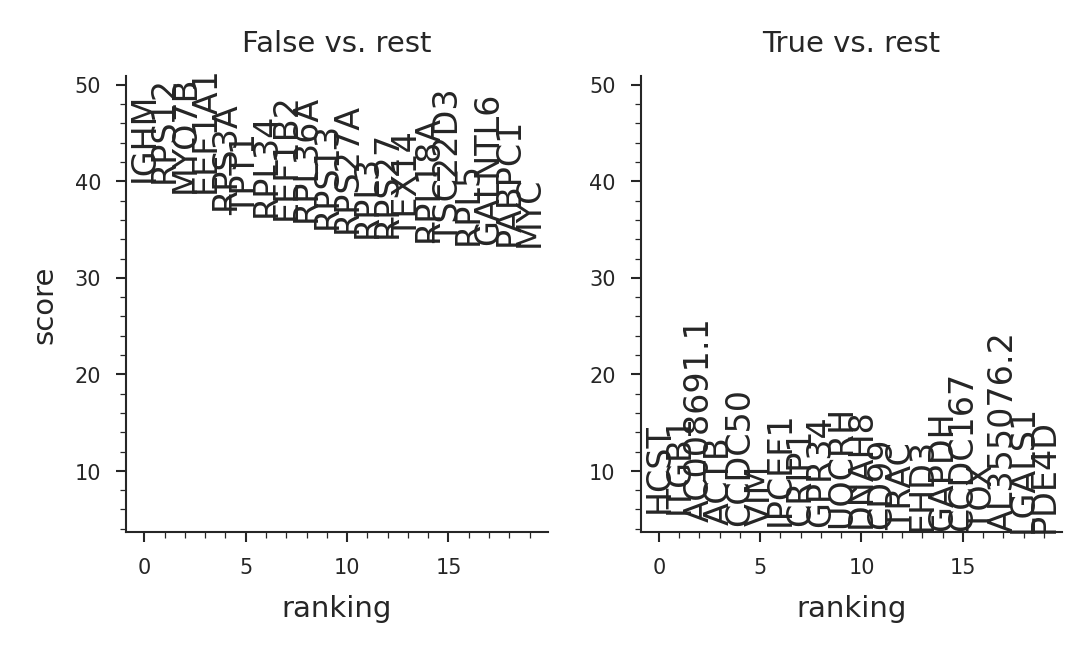

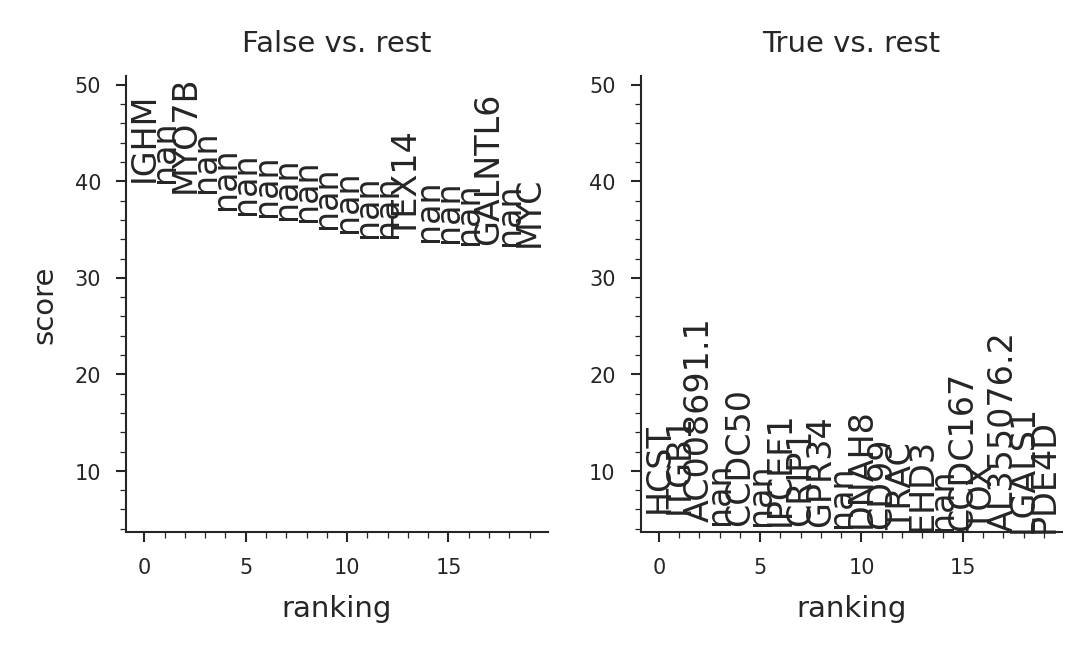

/home/michaelswift/miniconda3/envs/scanpy_new/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


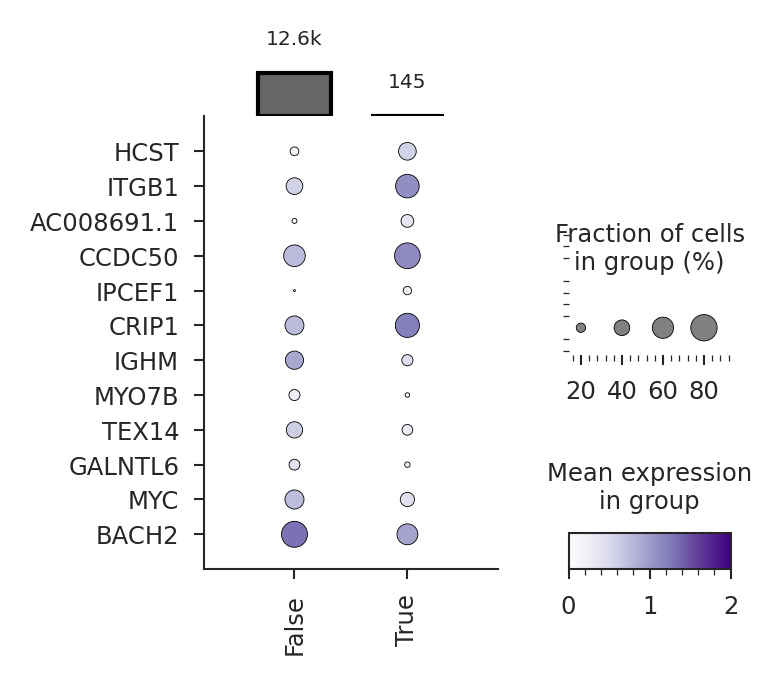

4908 cells
4908 cells after removing nans in shared

 LN_BM 
 as_cells 






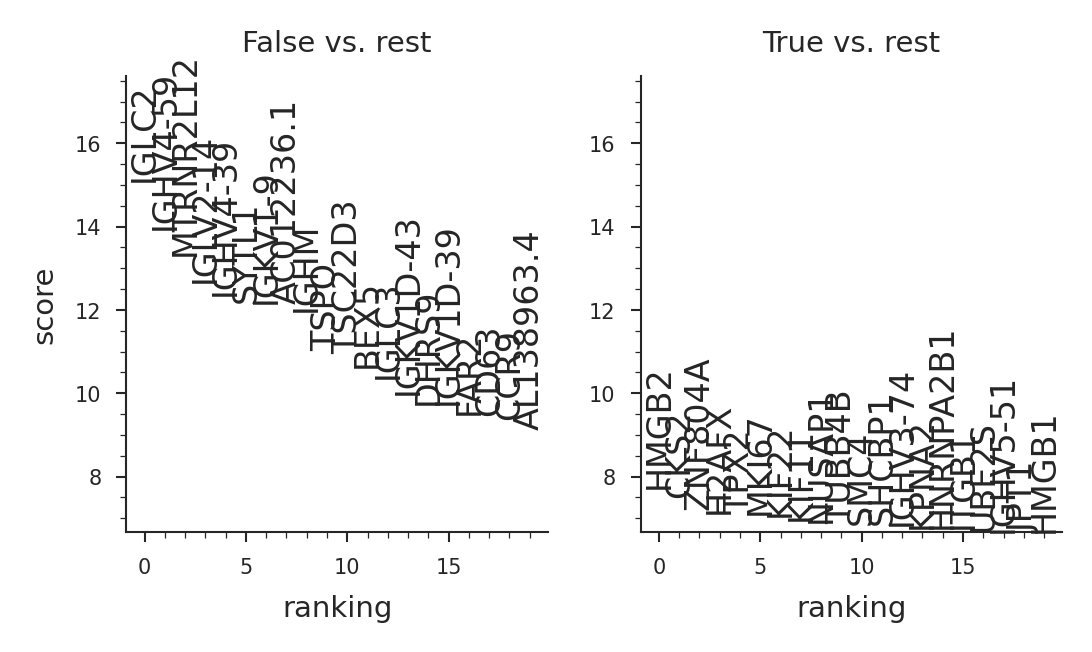

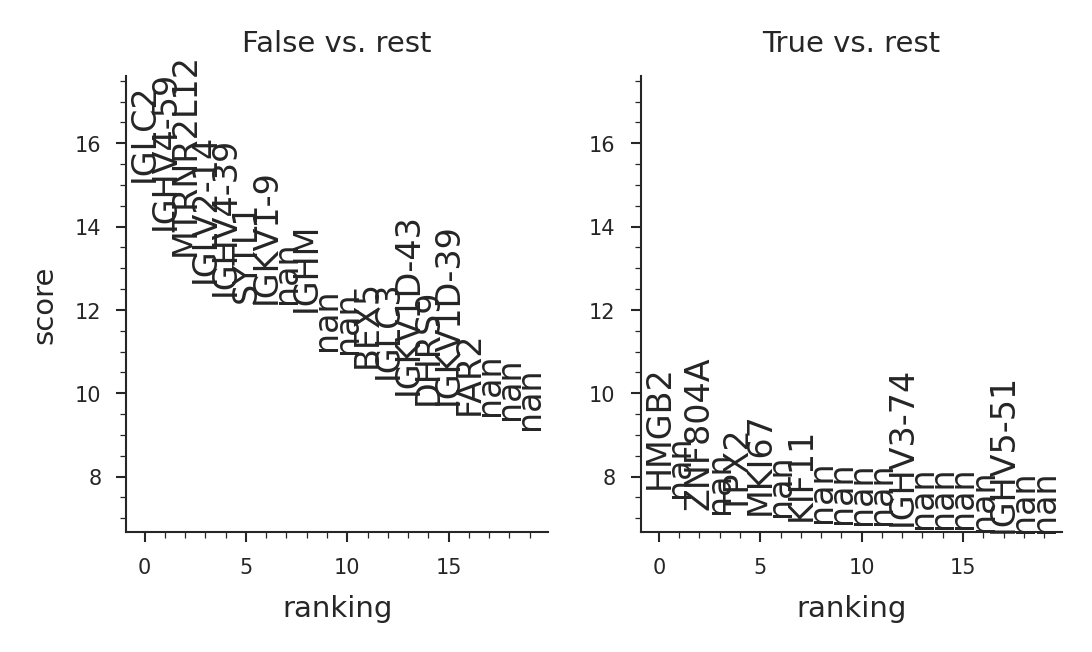

/home/michaelswift/miniconda3/envs/scanpy_new/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


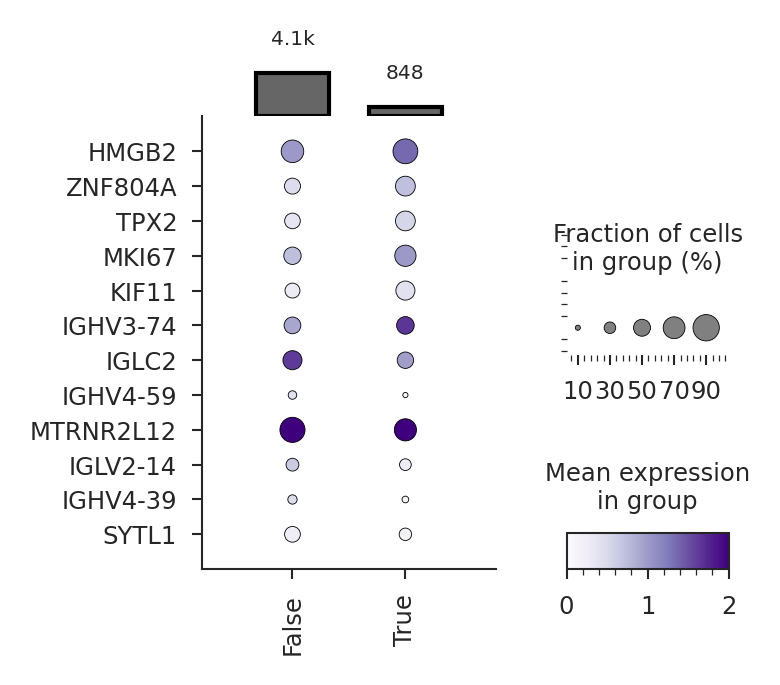

9204 cells
9204 cells after removing nans in shared

 LN_BM 
 LN_only 






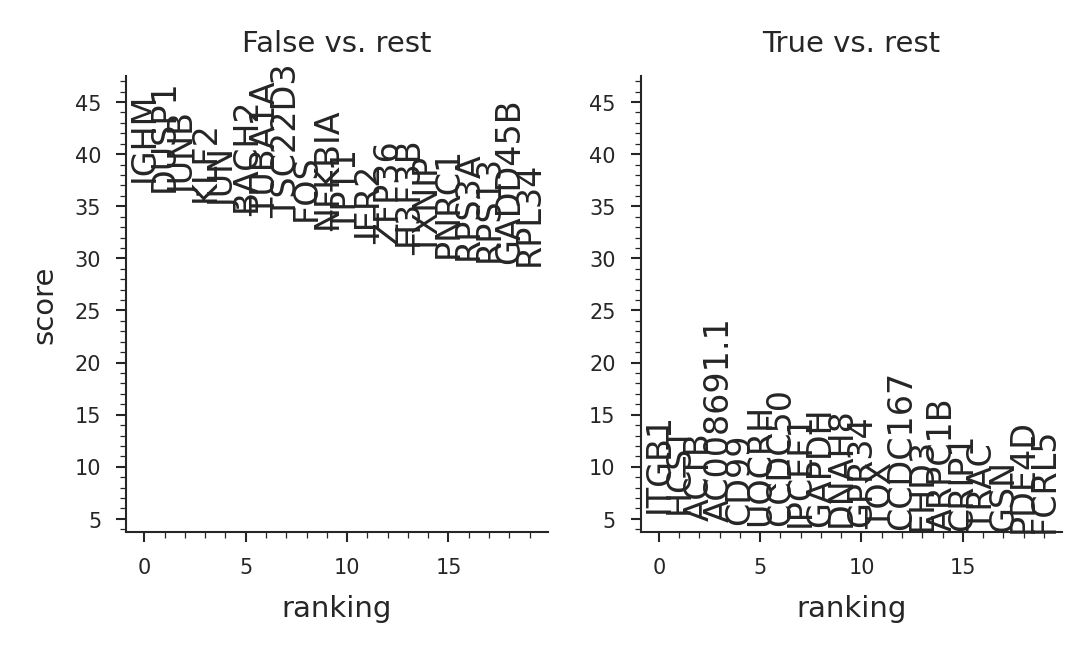

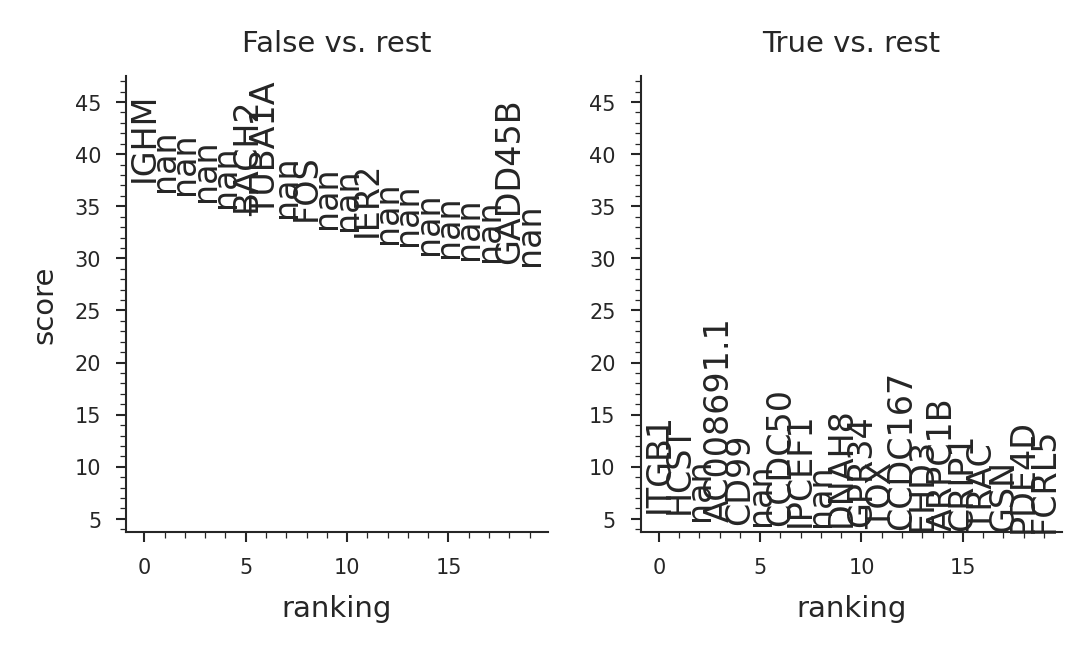

/home/michaelswift/miniconda3/envs/scanpy_new/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


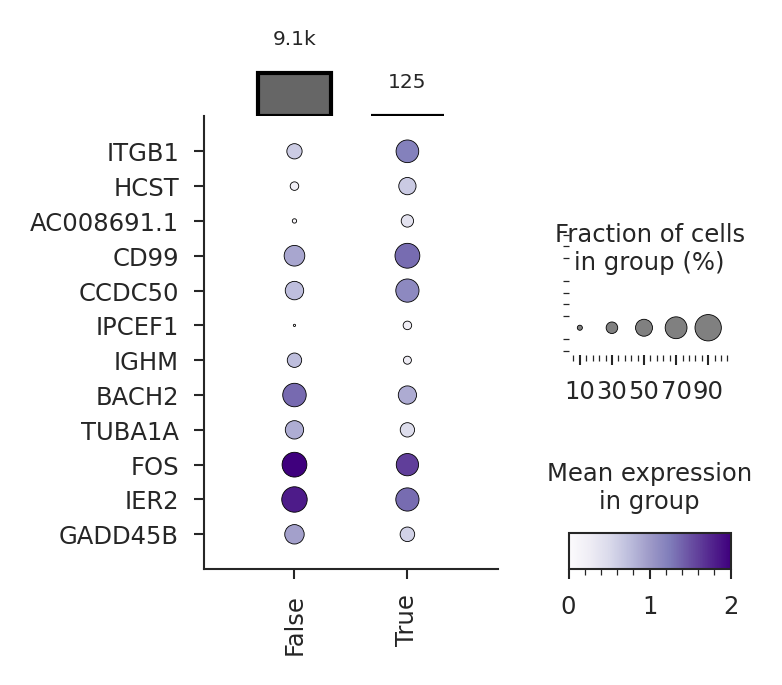

In [16]:
use_filtered_genes = True
for tissue_combo in tissue_combo_to_column.keys():
    # Dictionary to hold AnnData objects and their descriptors
    adata_dict = {'all_data': adata, 'mb_cells': mb_adata, 'as_cells':asc_adata, 'LN_only': mb_adata_LN}
    adata_dict = {'mb_cells': mb_adata, 'as_cells':asc_adata, 'LN_only': mb_adata_LN}

    # Loop through the dictionary
    for descriptor, ad in adata_dict.items():        
        ad.obs['shared'] = ad.obs[tissue_combo_to_column[tissue_combo]]
        # restrict to vdjs discovered in either tissue
        print(ad.shape[0], "cells")
        ad.obs['shared'] = ad.obs.shared.astype('category')
        #ad = ad[ad.obs.shared != 'nan']
        ad.obs.shared = ad.obs.shared.cat.remove_unused_categories()
        print(ad.shape[0], "cells after removing nans in shared")
        print("\n", tissue_combo, "\n", descriptor, "\n\n\n\n")
        # Perform ranking of genes
        method = 't-test_overestim_var'
        #key = f'shared_{method}'
        key = 'rank_genes_groups'
        sc.tl.rank_genes_groups(ad, groupby='shared', method=method, pts=True)
        sc.pl.rank_genes_groups(ad, key = key)
        sc.tl.filter_rank_genes_groups(ad,min_fold_change=0.69, min_in_group_fraction=0.05, max_out_group_fraction=0.8)
        # Plot ranked genes
        sc.pl.rank_genes_groups(ad, key='rank_genes_groups_filtered')
        
        # Get the DataFrame of ranked genes
        dedf_True = sc.get.rank_genes_groups_df(ad, group="True", key=key)
        dedf_False = sc.get.rank_genes_groups_df(ad, group="False", key=key)
        dedf_filtered_true = sc.get.rank_genes_groups_df(ad, group="True", key='rank_genes_groups_filtered')
        dedf_filtered_false = sc.get.rank_genes_groups_df(ad, group="False", key='rank_genes_groups_filtered')
        # custom dotplot need doc
        if use_filtered_genes:
            true_markers = dedf_filtered_true.dropna(subset = 'names')['names'][:6].to_list()
            false_markers = dedf_filtered_false.dropna(subset = 'names')['names'][:6].to_list()
        else:
            true_markers = dedf_True['names'][:6].to_list()
            false_markers = dedf_False['names'][:6].to_list()
        markers = true_markers + false_markers
        try:
            dp = plot_custom_dotplot(ad, markers)
        except:
            print("Dot plot tried with", len(markers), "could be an issue")
            pass
        # Create a folder for tissue_combo if it doesn't exist
        folder_path = f"{tissue_combo}/{descriptor}/"
        pathlib.Path(folder_path).mkdir(parents=True, exist_ok=True)
        # Save dedf_filtered to a file within the tissue_combo folder using f-string for the full path
        folder_path = f"{tissue_combo}/{descriptor}/"
        dedf_True.to_csv(f"{folder_path}_de_genes.tab", sep='\t')
        file_path = f"{folder_path}_filtered_de_genes_true.tab"
        dedf_filtered_true.to_csv(file_path, sep = '\t')
        file_path = f"{folder_path}_filtered_de_genes_false.tab"
        dedf_filtered_false.to_csv(file_path, sep = '\t')
        save_figure(dp.fig, f"dotplot_{descriptor}", output_dir=tissue_combo)